In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

In [2]:
pd.set_option('float_format', '{:f}'.format)

In [3]:
dados = pd.read_csv(open(r"D:\João\MBA\Diversos\TCC\Base Tratada v2 - 20181206.txt", 'r', encoding='utf8'), sep=';', low_memory=False)

In [4]:
def plotarFrequencia(dados, x):
    ncount = len(dados)
    plt.figure(figsize=(18,8))
    ax = sns.countplot(x=x, data=dados) #order=[3,4,5,6,7,8,9,10,11,12])
    plt.title('Distribuição de ' + str(x))
    plt.xlabel(str(x))

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax.set_ylabel('Quantidade')
    ax2.set_ylabel('Frequência [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

    #plt.savefig('snscounter.pdf')

In [5]:
dados.shape

(233665, 75)

In [6]:
dados.head()

,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,RGR_RFPF_CPF_PENDENTE,RGR_RFPF_CPF_SUSPENSO,RGR_RFPF_NOME_CONFERE,RGR_RI_DDD_CLI_IGUAL_UF_RES,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
0,35503764803,M,6,4,Até 1º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,N,N,S,S,S,S,548.000000,1,0,1
1,26757814870,F,16,19,Superior (Completo),Casado,PROFESSOR DE ENSINO MÉDIO,Própria,Funcionário Publico,0,...,N,N,S,S,S,N,579.000000,1,0,1
2,40837123844,F,6,10,Até 2º grau completo,Casado,AUTÔNOMO,Própria,Autônomo,0,...,N,N,S,S,NaN,NaN,571.000000,1,0,0
3,35955698817,M,0,8,Até 1º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,N,N,S,S,N,NaN,468.000000,1,0,1
4,34465033826,F,5,5,Superior (Incompleto),Solteiro,AUTÔNOMO,Alugada,Aposentado,0,...,N,N,S,S,NaN,NaN,606.000000,1,0,1


# Tratamento de outliers e missings

In [7]:
def tiposDeDados(dados):
    
    dic = {}
    quanti = []
    quali = []
    
    for i in dados.columns:
        dic[i] = str(dados[i].dtype)

    for feature, dtype in dic.items():
        if dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            quanti.append(feature)
        else:
            quali.append(feature)
        
    return quanti, quali

In [8]:
def dadosMissing(dados):
    #Apresenta todas as colunas que possuem missing
    for i in dados.columns:
        if sum(dados[i].isnull()) > 0:
            print(i + ' - ' + str(dados[i].dtype) + ':        ' + str(sum(dados[i].isnull())))

In [9]:
quanti, quali = tiposDeDados(dados)

In [10]:
dadosMissing(dados)

DIAS_ATRASO - float64:        225432
CASE_SCORE_X_LOJA - object:        12574
FLX_ACSP_VERIFICACAO_END - object:        15727
FLX_ANATEL - object:        15736
FLX_BOAVISTANET - object:        139455
FLX_IRPF - object:        15736
FLX_PRINCIPAL - object:        10020
FLX_RECEITA_FEDERAL_PF - object:        10037
FLX_RESTRICAO_INTERNA - object:        11398
GTWR_0001_SITUACAO_CADASTRAL - object:        23954
GTWR_0021_SITUACAO_DECLARACAO - object:        27325
GTWR_0021_STATUS - float64:        27325
GTWR_0021_TEM_DEBS - object:        27325
GTWR_0021_TEM_RESTITUICAO - object:        27325
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        153524
GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS - float64:        153524
GTWR_0182_QTDE_OUT_ATV_ECS - float64:        153524
GTWR_0182_QTDE_REGISTRADO - float64:        153524
GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        153524
GTWR_0182_QTDE_SCPC_CRED_CHQ - float64:        153524
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        153524
GTWR_0

In [11]:
quanti

['CPF',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'VLR_ENTRADA',
 'LIMITE',
 'DIAS_ATRASO',
 'GTWR_0021_STATUS',
 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS',
 'GTWR_0182_QTDE_OUT_ATV_ECS',
 'GTWR_0182_QTDE_REGISTRADO',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_CHQ',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'GTWR_0304_CHQ_FND_BACEN_QTDE_',
 'GTWR_0304_PENDS_FINS_QTDE_',
 'PROP_CEP_RESIDENCIAL',
 'PROP_CPF_TITULAR',
 'PROP_VALOR_RENDA_BRUTA',
 'SCORE_BV',
 'FLG_NAOPAGOU',
 'NOME_IGUAL_RECEITA',
 'NOME_IGUAL_BOAVISTA']

### Verificando se existem variáveis qualitativas que devem ser quantitativas ou vice-versa

In [12]:
quali

['SEXO',
 'ESCOLARIDADE',
 'ESTADOCIVIL',
 'PROFISSAO',
 'MORADIA',
 'OCUPACAO',
 'POSSUIVEICULO',
 'DATACADASTRO',
 'CASE_SCORE_X_LOJA',
 'FLX_ACSP_VERIFICACAO_END',
 'FLX_ANATEL',
 'FLX_BOAVISTANET',
 'FLX_IRPF',
 'FLX_PRINCIPAL',
 'FLX_RECEITA_FEDERAL_PF',
 'FLX_RESTRICAO_INTERNA',
 'GTWR_0001_SITUACAO_CADASTRAL',
 'GTWR_0021_SITUACAO_DECLARACAO',
 'GTWR_0021_TEM_DEBS',
 'GTWR_0021_TEM_RESTITUICAO',
 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS',
 'GTWR_0304_PENDS_FINS_VL_TOT_',
 'LOG_DH_INICIO',
 'LOG_NM_POLITICA',
 'PROP_DATA_NASCIMENTO_TITULAR',
 'RGR_ACSP_CADASTRO_LOCALIZ',
 'RGR_ACSP_CEP_CONFERE',
 'RGR_ACSP_CPF_TEM_RESTRICAO',
 'RGR_ACSP_DOC_ROUBADO',
 'RGR_ACSP_DT_NASC_CONFERE',
 'RGR_ACSP_DT_NASC_EXISTE',
 'RGR_ACSP_NOME_MAE_EXISTE',
 'RGR_ANATEL_PROF_NULO',
 'RGR_CARENCIA',
 'RGR_IRPF_NAO_DECLARADO',
 'RGR_IRPF_RENDA_MAIOR_QUE_PISO',
 'RGR_IRPF_SIST_RESPONDE',
 'RGR_NAT_OCUP_SEM_TEL_PROF',
 'RGR_NOME_MAE_CONFERE',
 'RGR_RFPF_CPF_CANCELADO',
 'RGR_RFPF_CPF_ENCONTRADO',
 'RGR_RFPF_CPF_

In [13]:
dados['GTWR_0304_PENDS_FINS_VL_TOT_'] = (dados['GTWR_0304_PENDS_FINS_VL_TOT_'].replace(',','.', regex=True).astype(float))

In [14]:
dados['GTWR_0304_PENDS_FINS_VL_TOT_'].head()

0   -1.000000
1   -1.000000
2   -1.000000
3   -1.000000
4   -1.000000
Name: GTWR_0304_PENDS_FINS_VL_TOT_, dtype: float64

In [15]:
dados = dados.drop(['LOG_DH_INICIO', 'LOG_NM_POLITICA'], axis=1)

In [16]:
quanti, quali = tiposDeDados(dados)

In [17]:
dados[quali].describe()

,SEXO,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,POSSUIVEICULO,DATACADASTRO,CASE_SCORE_X_LOJA,FLX_ACSP_VERIFICACAO_END,...,RGR_NAT_OCUP_SEM_TEL_PROF,RGR_NOME_MAE_CONFERE,RGR_RFPF_CPF_CANCELADO,RGR_RFPF_CPF_ENCONTRADO,RGR_RFPF_CPF_PENDENTE,RGR_RFPF_CPF_SUSPENSO,RGR_RFPF_NOME_CONFERE,RGR_RI_DDD_CLI_IGUAL_UF_RES,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE
count,233665,233665,233665,233665,233665,233665,233665,233665,221091,217938,...,148367,74509,209568,209734,209711,209658,209711,223627,135260,36268
unique,2,5,7,104,6,11,1,686,8,3,...,2,2,2,2,2,2,2,2,2,2
top,F,Até 2º grau completo,Casado,AUTÔNOMO,Própria,Autônomo,N,2017-12-16,A,SEGUIR - A,...,S,S,N,S,N,N,S,S,N,S
freq,163796,160202,134803,78066,214118,111728,233665,1704,134295,217311,...,136702,73702,209563,209711,209658,209568,187182,221317,98992,31992


In [18]:
quali

['SEXO',
 'ESCOLARIDADE',
 'ESTADOCIVIL',
 'PROFISSAO',
 'MORADIA',
 'OCUPACAO',
 'POSSUIVEICULO',
 'DATACADASTRO',
 'CASE_SCORE_X_LOJA',
 'FLX_ACSP_VERIFICACAO_END',
 'FLX_ANATEL',
 'FLX_BOAVISTANET',
 'FLX_IRPF',
 'FLX_PRINCIPAL',
 'FLX_RECEITA_FEDERAL_PF',
 'FLX_RESTRICAO_INTERNA',
 'GTWR_0001_SITUACAO_CADASTRAL',
 'GTWR_0021_SITUACAO_DECLARACAO',
 'GTWR_0021_TEM_DEBS',
 'GTWR_0021_TEM_RESTITUICAO',
 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS',
 'PROP_DATA_NASCIMENTO_TITULAR',
 'RGR_ACSP_CADASTRO_LOCALIZ',
 'RGR_ACSP_CEP_CONFERE',
 'RGR_ACSP_CPF_TEM_RESTRICAO',
 'RGR_ACSP_DOC_ROUBADO',
 'RGR_ACSP_DT_NASC_CONFERE',
 'RGR_ACSP_DT_NASC_EXISTE',
 'RGR_ACSP_NOME_MAE_EXISTE',
 'RGR_ANATEL_PROF_NULO',
 'RGR_CARENCIA',
 'RGR_IRPF_NAO_DECLARADO',
 'RGR_IRPF_RENDA_MAIOR_QUE_PISO',
 'RGR_IRPF_SIST_RESPONDE',
 'RGR_NAT_OCUP_SEM_TEL_PROF',
 'RGR_NOME_MAE_CONFERE',
 'RGR_RFPF_CPF_CANCELADO',
 'RGR_RFPF_CPF_ENCONTRADO',
 'RGR_RFPF_CPF_PENDENTE',
 'RGR_RFPF_CPF_SUSPENSO',
 'RGR_RFPF_NOME_CONFERE',
 'RGR_RI

In [19]:
quanti

['CPF',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'VLR_ENTRADA',
 'LIMITE',
 'DIAS_ATRASO',
 'GTWR_0021_STATUS',
 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS',
 'GTWR_0182_QTDE_OUT_ATV_ECS',
 'GTWR_0182_QTDE_REGISTRADO',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_CHQ',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'GTWR_0304_CHQ_FND_BACEN_QTDE_',
 'GTWR_0304_PENDS_FINS_QTDE_',
 'GTWR_0304_PENDS_FINS_VL_TOT_',
 'PROP_CEP_RESIDENCIAL',
 'PROP_CPF_TITULAR',
 'PROP_VALOR_RENDA_BRUTA',
 'SCORE_BV',
 'FLG_NAOPAGOU',
 'NOME_IGUAL_RECEITA',
 'NOME_IGUAL_BOAVISTA']

In [20]:
quali.append('PROP_CEP_RESIDENCIAL')
quali.append('FLG_NAOPAGOU')
quali.append('NOME_IGUAL_RECEITA')
quali.append('NOME_IGUAL_BOAVISTA')

In [21]:
quanti.remove('PROP_CEP_RESIDENCIAL')
quanti.remove('FLG_NAOPAGOU')
quanti.remove('NOME_IGUAL_RECEITA')
quanti.remove('NOME_IGUAL_BOAVISTA')

In [22]:
quali

['SEXO',
 'ESCOLARIDADE',
 'ESTADOCIVIL',
 'PROFISSAO',
 'MORADIA',
 'OCUPACAO',
 'POSSUIVEICULO',
 'DATACADASTRO',
 'CASE_SCORE_X_LOJA',
 'FLX_ACSP_VERIFICACAO_END',
 'FLX_ANATEL',
 'FLX_BOAVISTANET',
 'FLX_IRPF',
 'FLX_PRINCIPAL',
 'FLX_RECEITA_FEDERAL_PF',
 'FLX_RESTRICAO_INTERNA',
 'GTWR_0001_SITUACAO_CADASTRAL',
 'GTWR_0021_SITUACAO_DECLARACAO',
 'GTWR_0021_TEM_DEBS',
 'GTWR_0021_TEM_RESTITUICAO',
 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS',
 'PROP_DATA_NASCIMENTO_TITULAR',
 'RGR_ACSP_CADASTRO_LOCALIZ',
 'RGR_ACSP_CEP_CONFERE',
 'RGR_ACSP_CPF_TEM_RESTRICAO',
 'RGR_ACSP_DOC_ROUBADO',
 'RGR_ACSP_DT_NASC_CONFERE',
 'RGR_ACSP_DT_NASC_EXISTE',
 'RGR_ACSP_NOME_MAE_EXISTE',
 'RGR_ANATEL_PROF_NULO',
 'RGR_CARENCIA',
 'RGR_IRPF_NAO_DECLARADO',
 'RGR_IRPF_RENDA_MAIOR_QUE_PISO',
 'RGR_IRPF_SIST_RESPONDE',
 'RGR_NAT_OCUP_SEM_TEL_PROF',
 'RGR_NOME_MAE_CONFERE',
 'RGR_RFPF_CPF_CANCELADO',
 'RGR_RFPF_CPF_ENCONTRADO',
 'RGR_RFPF_CPF_PENDENTE',
 'RGR_RFPF_CPF_SUSPENSO',
 'RGR_RFPF_NOME_CONFERE',
 'RGR_RI

In [23]:
quanti

['CPF',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'VLR_ENTRADA',
 'LIMITE',
 'DIAS_ATRASO',
 'GTWR_0021_STATUS',
 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS',
 'GTWR_0182_QTDE_OUT_ATV_ECS',
 'GTWR_0182_QTDE_REGISTRADO',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_CHQ',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'GTWR_0304_CHQ_FND_BACEN_QTDE_',
 'GTWR_0304_PENDS_FINS_QTDE_',
 'GTWR_0304_PENDS_FINS_VL_TOT_',
 'PROP_CPF_TITULAR',
 'PROP_VALOR_RENDA_BRUTA',
 'SCORE_BV']

In [24]:
dados[quanti].describe(percentiles=[.25, .5, .75, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,VLR_ENTRADA,LIMITE,DIAS_ATRASO,GTWR_0021_STATUS,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS,...,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_CRED_VEICULOS,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV
count,233665.000000,233665.000000,233665.000000,233665.000000,233665.000000,233665.000000,233665.000000,8233.000000,206340.000000,80141.000000,...,80141.000000,80141.000000,80141.000000,80141.000000,216433.000000,216433.000000,216433.000000,233665.000000,223645.000000,223408.000000
mean,27673623981.554977,3.845946,12.197826,0.000342,0.000757,16.711646,609.590563,279.356492,0.222599,0.015635,...,0.010070,0.000911,0.094396,0.299884,0.022547,-0.004759,2.142036,27673623981.554977,1822.207011,679.341326
std,20944962993.865002,5.257632,9.545690,0.020890,0.036002,98.588890,291.515207,179.449643,0.415992,0.262197,...,0.114838,0.032555,0.385973,0.701347,0.427531,0.176458,326.883404,20944962993.865002,22145.850367,155.572435
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,181200.000000,678.790000,-1.000000
25%,11531033890.000000,0.000000,5.000000,0.000000,0.000000,0.000000,440.000000,96.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,11531033890.000000,1200.000000,580.000000
50%,26463416878.000000,2.000000,10.000000,0.000000,0.000000,0.000000,570.000000,303.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,26463416878.000000,1500.000000,685.000000
75%,36168751882.000000,6.000000,16.000000,0.000000,0.000000,0.000000,780.000000,411.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,36168751882.000000,2000.000000,797.000000
95%,76867055676.799942,16.000000,30.000000,0.000000,0.000000,0.000000,1170.000000,583.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,-1.000000,76867055676.799942,3100.000000,897.000000
max,99996359891.000000,67.000000,78.000000,2.000000,4.000000,1389.630000,2000.000000,691.000000,1.000000,18.000000,...,4.000000,3.000000,7.000000,17.000000,34.000000,54.000000,64128.050000,99996359891.000000,10003000.000000,999.000000


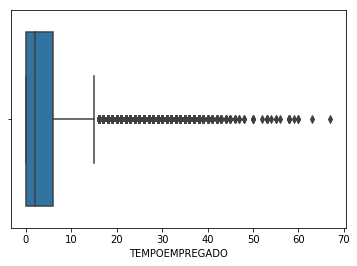

In [25]:
sns.boxplot(dados['TEMPOEMPREGADO'])

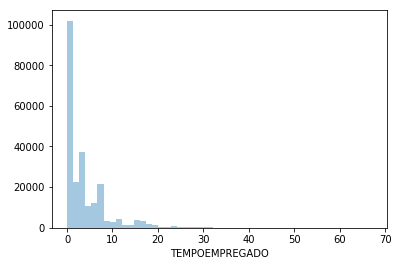

In [26]:
sns.distplot(dados['TEMPOEMPREGADO'], kde=False)

In [27]:
def outliersIndexes(feature):
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    
    return np.where((feature > upper) | (feature < lower))

In [28]:
outliers = outliersIndexes(dados['TEMPOEMPREGADO'])

In [29]:
# dados.loc[~dados.index.isin(outliers[0])].count() #not in
#dados.loc[outliers]

In [30]:
dados.loc[outliers][['TEMPOEMPREGADO', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,TEMPOEMPREGADO
FLG_NAOPAGOU,
0,12297
1,265


In [31]:
# Parecia ser outlier mas não é.
dados.loc[outliers][['TEMPOEMPREGADO', 'FLG_NAOPAGOU']].describe(percentiles=[.25, .50, .75, .9, .95])

,TEMPOEMPREGADO,FLG_NAOPAGOU
count,12562.000000,12562.000000
mean,20.228308,0.021095
std,5.171644,0.143708
min,16.000000,0.000000
25%,17.000000,0.000000
50%,18.000000,0.000000
75%,22.000000,0.000000
90%,27.000000,0.000000
95%,30.000000,0.000000
max,67.000000,1.000000


In [32]:
# Acima de 40 anos de trabalho, restam 
dados[dados['TEMPOEMPREGADO'] > 40].describe()

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,VLR_ENTRADA,LIMITE,DIAS_ATRASO,GTWR_0021_STATUS,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,0.000000,65.000000,25.000000,...,75.000000,75.000000,75.000000,76.000000,79.000000,76.000000,76.000000,79.000000,79.000000,79.000000
mean,34615496476.924049,46.822785,16.784810,0.000000,0.000000,0.000000,705.759494,nan,0.430769,0.000000,...,0.000000,0.000000,-1.000000,8861692.644737,34615496476.924049,2348.842632,772.263158,0.000000,0.341772,0.278481
std,33316948657.354031,6.486197,11.567717,0.000000,0.000000,0.000000,308.199620,nan,0.499038,0.000000,...,0.000000,0.000000,0.000000,5510610.339162,33316948657.354031,1636.907118,113.440659,0.000000,0.477334,0.451116
min,15306828.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,...,0.000000,0.000000,-1.000000,2055040.000000,15306828.000000,935.000000,330.000000,0.000000,0.000000,0.000000
25%,7341412327.500000,42.000000,10.000000,0.000000,0.000000,0.000000,529.000000,nan,0.000000,0.000000,...,0.000000,0.000000,-1.000000,4852370.000000,7341412327.500000,1400.000000,695.000000,0.000000,0.000000,0.000000
50%,19529522800.000000,44.000000,15.000000,0.000000,0.000000,0.000000,600.000000,nan,0.000000,0.000000,...,0.000000,0.000000,-1.000000,7224017.500000,19529522800.000000,1900.000000,778.500000,0.000000,0.000000,0.000000
75%,71504286868.000000,51.000000,24.000000,0.000000,0.000000,0.000000,877.500000,nan,1.000000,0.000000,...,0.000000,0.000000,-1.000000,11722643.750000,71504286868.000000,2800.000000,858.000000,0.000000,1.000000,1.000000
max,99574144887.000000,67.000000,52.000000,0.000000,0.000000,0.000000,1800.000000,nan,1.000000,0.000000,...,0.000000,0.000000,-1.000000,37464000.000000,99574144887.000000,10000.000000,953.000000,0.000000,1.000000,1.000000


## Referência para o tempo de contribuição para aposentadoria

https://www.inss.gov.br/beneficios/aposentadoria-por-tempo-de-contribuicao/

In [33]:
# Nenhum cliente com mais de 40 anos trabalhados deixou de pagar sua fatura.
# Logo, decido por remover estas observações com o objetivo de eliminar os ouliers.
dados[dados['TEMPOEMPREGADO'] > 40][['TEMPOEMPREGADO', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,TEMPOEMPREGADO
FLG_NAOPAGOU,
0,79


In [34]:
dados = dados[dados['TEMPOEMPREGADO'] <= 40]

In [35]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,VLR_ENTRADA,LIMITE,DIAS_ATRASO,GTWR_0021_STATUS,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,233586.000000,233586.000000,233586.000000,233586.000000,233586.000000,233586.000000,233586.000000,8233.000000,206275.000000,80116.000000,...,216358.000000,216358.000000,216358.000000,223569.000000,233586.000000,223569.000000,223332.000000,233586.000000,233586.000000,233586.000000
mean,27671276204.174767,3.831411,12.196275,0.000342,0.000758,16.717298,609.558039,279.356492,0.222533,0.015640,...,0.022555,-0.004761,2.143125,9230639.811723,27671276204.174767,1822.027987,679.309705,0.035246,0.244304,0.290022
std,20939266365.015915,5.197414,9.544591,0.020894,0.036008,98.605081,291.504733,179.449643,0.415948,0.262238,...,0.427605,0.176488,326.940051,5849155.917170,20939266365.015915,22149.591772,155.575570,0.184402,0.429675,0.453773
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11531376079.250000,0.000000,5.000000,0.000000,0.000000,0.000000,440.000000,96.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6243230.000000,11531376079.250000,1200.000000,580.000000,0.000000,0.000000,0.000000
50%,26463774825.000000,2.000000,10.000000,0.000000,0.000000,0.000000,570.000000,303.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8526020.000000,26463774825.000000,1500.000000,685.000000,0.000000,0.000000,0.000000
75%,36166715375.500000,6.000000,16.000000,0.000000,0.000000,0.000000,780.000000,411.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36166715375.500000,2000.000000,797.000000,0.000000,0.000000,1.000000
90%,50055210377.000000,10.000000,25.000000,0.000000,0.000000,0.000000,900.000000,553.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13225440.000000,50055210377.000000,2600.000000,865.000000,0.000000,1.000000,1.000000
95%,76855279071.750000,16.000000,30.000000,0.000000,0.000000,0.000000,1170.000000,583.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13632390.000000,76855279071.750000,3100.000000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,78.000000,2.000000,4.000000,1389.630000,2000.000000,691.000000,1.000000,18.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


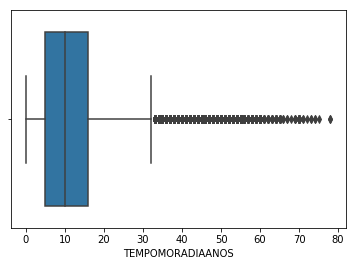

In [36]:
sns.boxplot(dados['TEMPOMORADIAANOS'])

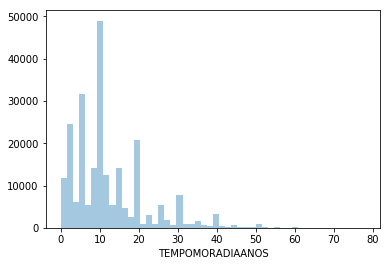

In [37]:
sns.distplot(dados['TEMPOMORADIAANOS'], kde=False)

In [38]:
outliers = outliersIndexes(dados['TEMPOMORADIAANOS'])

In [39]:
dados.loc[outliers]

C:\Users\joaoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,RGR_RFPF_CPF_PENDENTE,RGR_RFPF_CPF_SUSPENSO,RGR_RFPF_NOME_CONFERE,RGR_RI_DDD_CLI_IGUAL_UF_RES,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
35,7335162890.000000,F,3.000000,35.000000,Superior (Completo),Casado,AUTÔNOMO,Própria,Autônomo,0.000000,...,N,N,S,S,NaN,NaN,594.000000,1.000000,0.000000,1.000000
90,43403916898.000000,M,0.000000,37.000000,Até 2º grau completo,Solteiro,APOSENTADOS EM GERAL,Própria,Aposentado,0.000000,...,N,N,S,S,S,S,690.000000,1.000000,0.000000,1.000000
111,15903998895.000000,F,3.000000,35.000000,Outros,Solteiro,APOSENTADOS EM GERAL,Própria,Aposentado,0.000000,...,NaN,NaN,NaN,S,N,NaN,658.000000,1.000000,0.000000,1.000000
119,99326000753.000000,F,0.000000,35.000000,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0.000000,...,N,N,S,S,N,NaN,855.000000,1.000000,0.000000,1.000000
123,3964514896.000000,F,7.000000,34.000000,Outros,Casado,OUTROS GRUPO 12,Própria,Empregado,0.000000,...,N,N,S,S,NaN,NaN,617.000000,1.000000,0.000000,1.000000
155,639327842.000000,M,0.000000,37.000000,Até 2º grau completo,Casado,ELETRICISTA DE MANUTENÇÃO DE VEÍCULOS MÁQUINAS...,Própria,Empregado,0.000000,...,N,N,S,S,NaN,NaN,718.000000,1.000000,0.000000,1.000000
286,16626332899.000000,F,1.000000,40.000000,Até 1º grau completo,Solteiro,CABELEREIRO / BARBEIRO / MANICURE / PEDICURE /...,Própria,Autônomo,0.000000,...,N,N,S,S,N,NaN,765.000000,1.000000,0.000000,0.000000
303,17748767874.000000,F,0.000000,40.000000,Outros,Casado,AUTÔNOMO,Própria,Autônomo,0.000000,...,N,N,S,S,NaN,NaN,625.000000,1.000000,0.000000,1.000000
378,31082838802.000000,F,0.000000,35.000000,Até 2º grau completo,Casado,AUTÔNOMO,Própria,Autônomo,0.000000,...,N,N,S,S,N,NaN,815.000000,1.000000,0.000000,1.000000
472,22715401868.000000,F,0.000000,47.000000,Até 1º grau completo,Casado,APOSENTADOS EM GERAL,Própria,Aposentado,0.000000,...,N,N,S,S,NaN,NaN,623.000000,1.000000,0.000000,1.000000


In [40]:
dados.loc[outliers][['TEMPOMORADIAANOS', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

C:\Users\joaoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,TEMPOMORADIAANOS
FLG_NAOPAGOU,
0.000000,9689
1.000000,197


In [41]:
# Parecia ser outlier mas não é.
dados.loc[outliers][['TEMPOMORADIAANOS', 'FLG_NAOPAGOU']].describe(percentiles=[.25, .50, .75, .9, .95, .99])

C:\Users\joaoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


,TEMPOMORADIAANOS,FLG_NAOPAGOU
count,9886.000000,9886.000000
mean,13.012745,0.019927
std,10.672256,0.139757
min,0.000000,0.000000
25%,5.000000,0.000000
50%,10.000000,0.000000
75%,17.000000,0.000000
90%,30.000000,0.000000
95%,37.000000,0.000000
99%,49.000000,1.000000


In [42]:
dados[dados['TEMPOMORADIAANOS'] > 50]

,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,RGR_RFPF_CPF_PENDENTE,RGR_RFPF_CPF_SUSPENSO,RGR_RFPF_NOME_CONFERE,RGR_RI_DDD_CLI_IGUAL_UF_RES,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
1222,19004109900,M,0,64,Até 1º grau completo,Casado,APOSENTADOS EM GERAL,Própria,Aposentado,0,...,N,N,S,N,N,NaN,788.000000,1,0,1
1866,46853278887,M,0,54,Até 1º grau completo,Solteiro,APOSENTADOS EM GERAL,Própria,Aposentado,0,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,1,0,0
2491,9002749805,M,0,52,Até 1º grau completo,Solteiro,MOTORISTA AUTÔNOMO / TAXISTA,Própria,Autônomo,0,...,N,N,S,S,N,NaN,745.000000,1,0,1
3434,39636407827,M,0,52,Até 1º grau completo,Solteiro,APOSENTADOS EM GERAL,Própria,Aposentado,0,...,N,N,S,S,S,S,505.000000,1,0,0
3463,9722662830,F,0,56,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,N,N,S,S,N,NaN,776.000000,1,0,0
3821,31014484847,F,7,65,Superior (Completo),Casado,APOSENTADOS EM GERAL,Própria,Aposentado,0,...,N,N,S,S,N,NaN,585.000000,1,0,0
4399,6580005866,M,1,52,Até 2º grau completo,Solteiro,AJUD. GERAL / AUX. SERV. GERAIS / AJUD. DE PED...,Própria,Empregado,0,...,N,N,S,S,NaN,NaN,726.000000,1,0,0
4817,724932836,F,0,58,Até 1º grau completo,Solteiro,APOSENTADOS EM GERAL,Própria,Aposentado,0,...,N,N,N,S,S,S,569.000000,1,0,0
8385,4665141827,F,2,53,Até 2º grau completo,Divorciado,AJUD. GERAL / AUX. SERV. GERAIS / AJUD. DE PED...,Própria,Empregado,0,...,N,N,S,S,NaN,NaN,777.000000,0,0,1
8863,90691547815,F,22,67,Até 2º grau completo,Casado,FUNCIONÁRIO DE EMPRESAS PÚBLICAS,Própria,Funcionário Publico,0,...,N,N,S,S,NaN,NaN,884.000000,0,0,1


In [43]:
dados[dados['TEMPOMORADIAANOS'] > 50][['TEMPOMORADIAANOS', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,TEMPOMORADIAANOS
FLG_NAOPAGOU,
0,539
1,8


In [44]:
# Removido alguns outliers
dados = dados[dados['TEMPOMORADIAANOS'] < 50]

In [45]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,VLR_ENTRADA,LIMITE,DIAS_ATRASO,GTWR_0021_STATUS,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,8214.000000,204980.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,16.776172,609.002257,279.343682,0.222339,0.015739,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,98.723807,291.427806,179.472704,0.415819,0.263069,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,0.000000,440.000000,96.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,0.000000,570.000000,303.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,0.000000,780.000000,411.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,0.000000,900.000000,553.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,0.000000,1170.000000,583.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,1389.630000,2000.000000,691.000000,1.000000,18.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


In [46]:
# Features removidas pois somente os clientes que atrasaram as possui, o que enviesa o modelo.
# 'GTWR_0021_STATUS' removida por não saber o significado
dados = dados.drop(['DIAS_ATRASO', 'VLR_ENTRADA', 'GTWR_0021_STATUS'], axis=1)

In [47]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS,GTWR_0182_QTDE_OUT_ATV_ECS,GTWR_0182_QTDE_REGISTRADO,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.015739,0.001809,0.009710,0.036290,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.263069,0.071917,0.183531,0.210223,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,18.000000,7.000000,16.000000,6.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


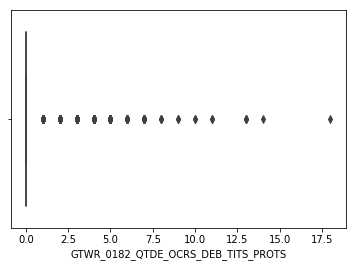

In [48]:
sns.boxplot(dados['GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS'])

In [49]:
# Não há títulos protestados nos primeiro 95% das observações
dados[['GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS']].describe(percentiles=[.25, .50, .75, .9, .95])

,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS
count,79609.000000
mean,0.015739
std,0.263069
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000
95%,0.000000
max,18.000000


In [50]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS']][['GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS
FLG_NAOPAGOU,
0,77351
1,2258


In [51]:
# Das observações que tinham títulos protestados, apenas 1 não pagou
dados[dados['GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS
FLG_NAOPAGOU,
0,520
1,1


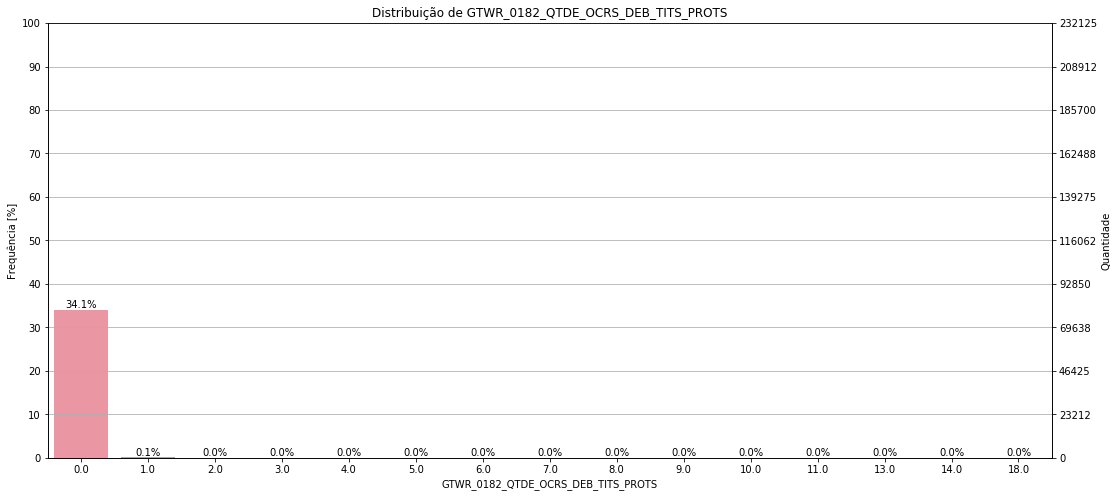

In [52]:
plotarFrequencia(dados, 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS')

In [53]:
dados = dados.drop('GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS', axis=1)

In [54]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_OUT_ATV_ECS,GTWR_0182_QTDE_REGISTRADO,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_CHQ,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.001809,0.009710,0.036290,0.000251,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.071917,0.183531,0.210223,0.016622,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,7.000000,16.000000,6.000000,2.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


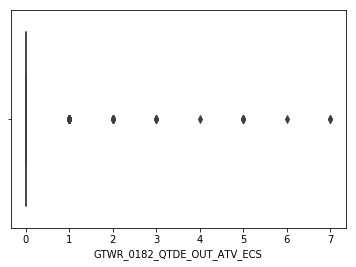

In [55]:
sns.boxplot(dados['GTWR_0182_QTDE_OUT_ATV_ECS'])

In [56]:
dados[['GTWR_0182_QTDE_OUT_ATV_ECS']].describe(percentiles=[.25, .50, .75, .9, .95])

,GTWR_0182_QTDE_OUT_ATV_ECS
count,79609.000000
mean,0.001809
std,0.071917
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000
95%,0.000000
max,7.000000


In [57]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_OUT_ATV_ECS']][['GTWR_0182_QTDE_OUT_ATV_ECS', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_OUT_ATV_ECS
FLG_NAOPAGOU,
0,77351
1,2258


In [58]:
# Das observações que tinham esta feature, apenas 1 não pagou
dados[dados['GTWR_0182_QTDE_OUT_ATV_ECS'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_OUT_ATV_ECS']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_OUT_ATV_ECS
FLG_NAOPAGOU,
0,87


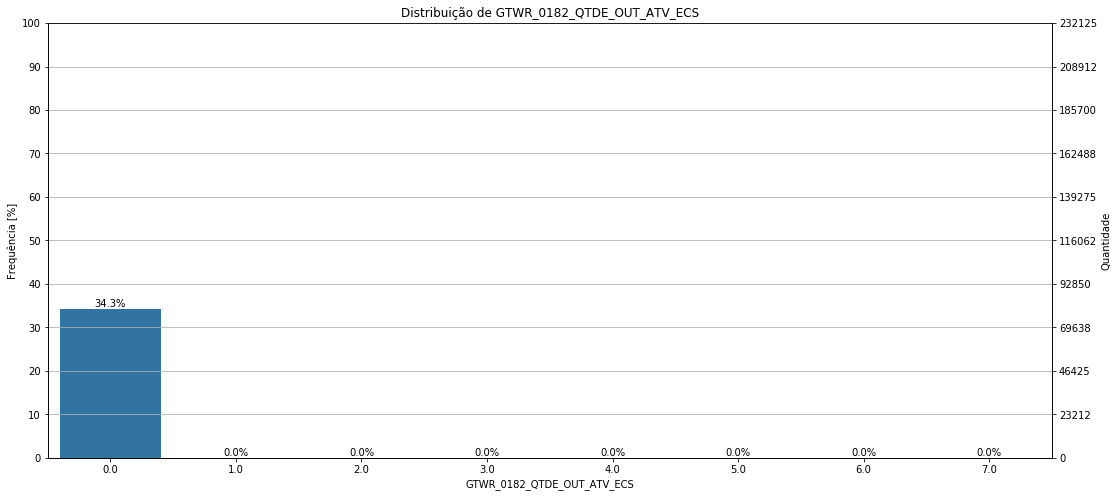

In [59]:
plotarFrequencia(dados, 'GTWR_0182_QTDE_OUT_ATV_ECS')

In [60]:
dados = dados.drop('GTWR_0182_QTDE_OUT_ATV_ECS', axis=1)

In [61]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_REGISTRADO,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_CHQ,GTWR_0182_QTDE_SCPC_CRED_DIRETO,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.009710,0.036290,0.000251,0.157683,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.183531,0.210223,0.016622,0.477743,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,16.000000,6.000000,2.000000,14.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


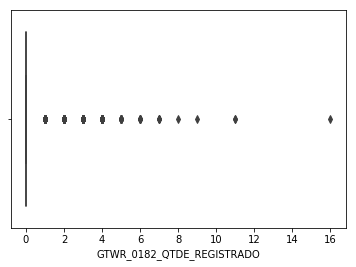

In [62]:
sns.boxplot(dados['GTWR_0182_QTDE_REGISTRADO'])

In [63]:
dados[['GTWR_0182_QTDE_REGISTRADO']].describe(percentiles=[.25, .50, .75, .9, .95])

,GTWR_0182_QTDE_REGISTRADO
count,79609.000000
mean,0.009710
std,0.183531
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000
95%,0.000000
max,16.000000


In [64]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_REGISTRADO']][['GTWR_0182_QTDE_REGISTRADO', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_REGISTRADO
FLG_NAOPAGOU,
0,77351
1,2258


In [65]:
# Das observações que foram registradas, apenas 1 virou FPD
dados[dados['GTWR_0182_QTDE_REGISTRADO'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_REGISTRADO']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_REGISTRADO
FLG_NAOPAGOU,
0,378
1,1


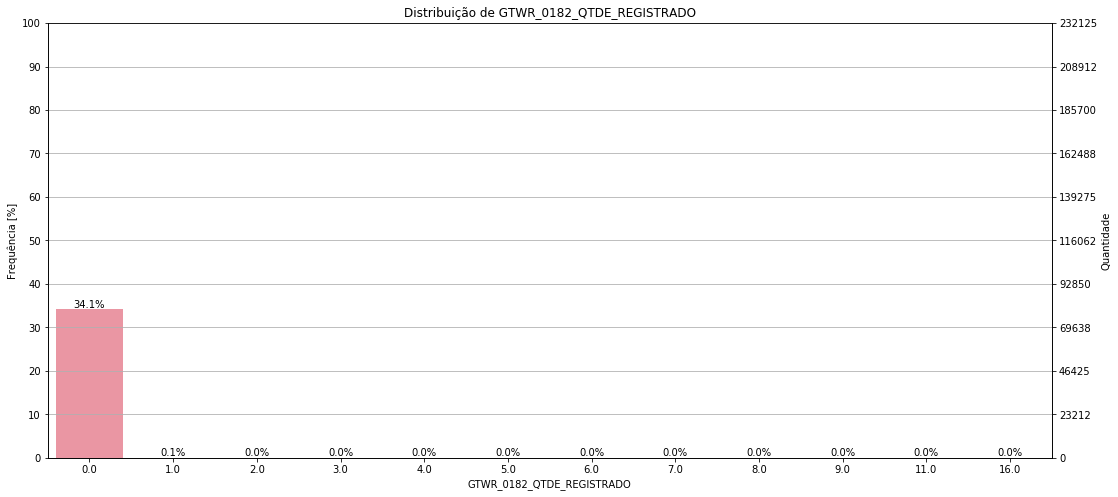

In [66]:
plotarFrequencia(dados, 'GTWR_0182_QTDE_REGISTRADO')

In [67]:
dados = dados.drop('GTWR_0182_QTDE_REGISTRADO', axis=1)

In [68]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_CHQ,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.000251,0.157683,0.010099,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.016622,0.477743,0.115058,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,2.000000,14.000000,4.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


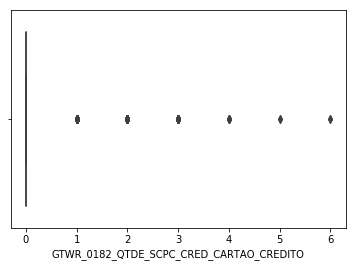

In [69]:
sns.boxplot(dados['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO'])

In [70]:
dados[['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO']].describe(percentiles=[.25, .50, .75, .9, .95])

,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO
count,79609.000000
mean,0.036290
std,0.210223
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000
95%,0.000000
max,6.000000


In [71]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO']][['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO
FLG_NAOPAGOU,
0,77351
1,2258


In [72]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO
FLG_NAOPAGOU,
0,2387
1,212


In [73]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO'] > 0][['CPF', 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO']].groupby('GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO').count()

,CPF
GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,
1.000000,2362
2.000000,200
3.000000,27
4.000000,6
5.000000,2
6.000000,2


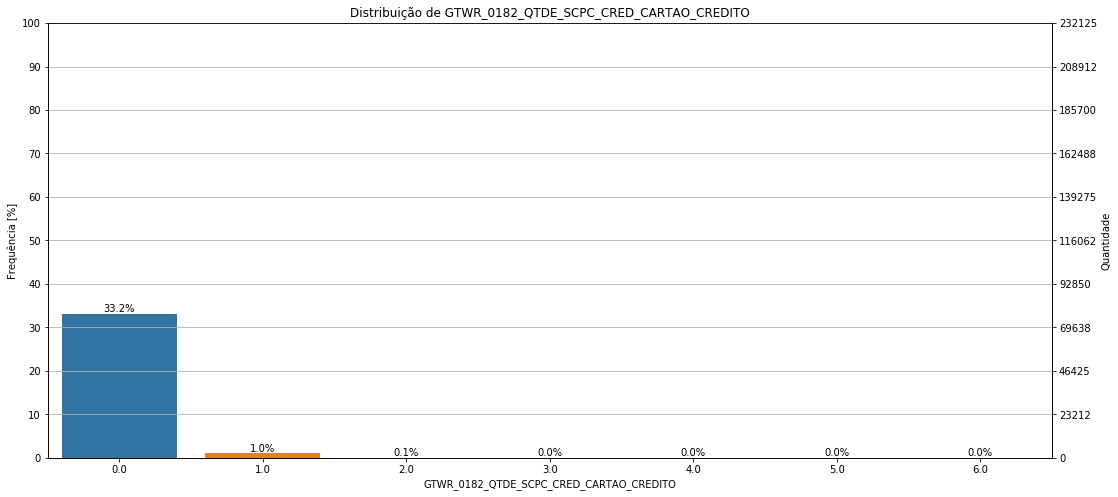

In [74]:
plotarFrequencia(dados, 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO')

In [75]:
def registroCartaoCredito(x):
    if x == 0:
        return 'NAO'
    elif x >= 1:
        return 'SIM'
    else:
        return None

## TODO: avaliar se não é melhor manter as quantidades e utilizar a feature como quantitativa discreta

In [76]:
dados['TEVE_REG_CARTAO_CREDITO'] = dados['GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO'].apply(registroCartaoCredito)

In [77]:
dados.shape

(232125, 68)

In [78]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['TEVE_REG_CARTAO_CREDITO'] == 'SIM'][['FLG_NAOPAGOU', 'TEVE_REG_CARTAO_CREDITO']].groupby('FLG_NAOPAGOU').count()

,TEVE_REG_CARTAO_CREDITO
FLG_NAOPAGOU,
0,2387
1,212


In [79]:
#dados = dados.drop('GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO', axis=1)

In [80]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_CHQ,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.000251,0.157683,0.010099,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.016622,0.477743,0.115058,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,2.000000,14.000000,4.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


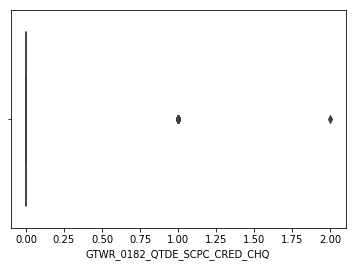

In [81]:
sns.boxplot(dados['GTWR_0182_QTDE_SCPC_CRED_CHQ'])

In [82]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_CHQ']][['GTWR_0182_QTDE_SCPC_CRED_CHQ', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_CHQ
FLG_NAOPAGOU,
0,77351
1,2258


In [83]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_CHQ'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_CHQ']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_CHQ
FLG_NAOPAGOU,
0,19


In [84]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_CHQ'] > 0][['CPF', 'GTWR_0182_QTDE_SCPC_CRED_CHQ']].groupby('GTWR_0182_QTDE_SCPC_CRED_CHQ').count()

,CPF
GTWR_0182_QTDE_SCPC_CRED_CHQ,
1.000000,18
2.000000,1


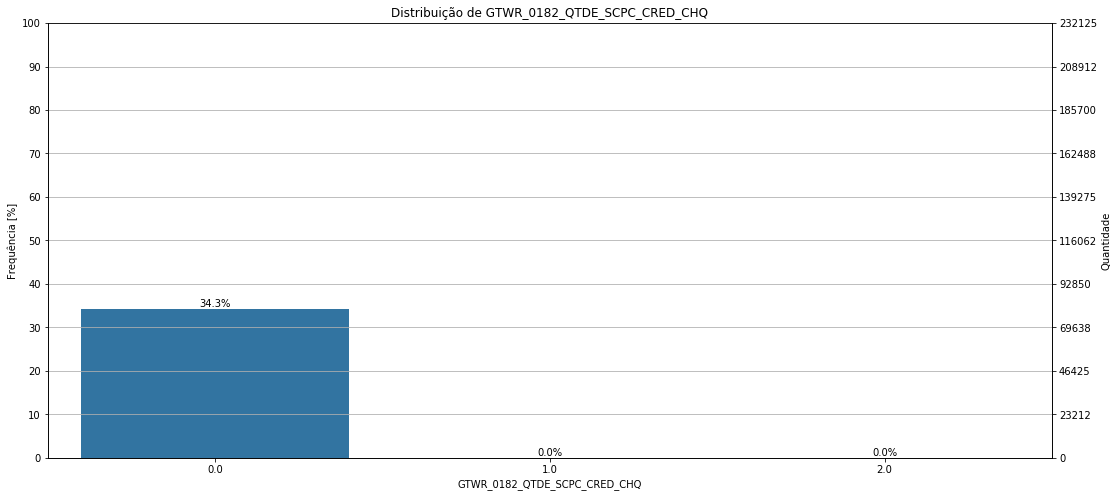

In [85]:
plotarFrequencia(dados, 'GTWR_0182_QTDE_SCPC_CRED_CHQ')

In [86]:
# Feature removida pois só há 19 casos acima de 0 contra 79590
dados = dados.drop('GTWR_0182_QTDE_SCPC_CRED_CHQ', axis=1)

In [87]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_CRED_VEICULOS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.000917,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.032663,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,3.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


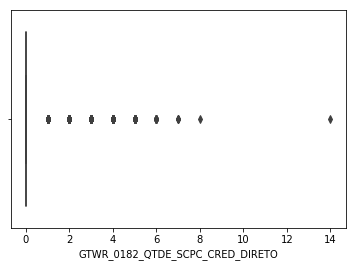

In [88]:
sns.boxplot(dados['GTWR_0182_QTDE_SCPC_CRED_DIRETO'])

In [89]:
dados[['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_DIRETO']][['GTWR_0182_QTDE_SCPC_CRED_DIRETO', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_DIRETO
FLG_NAOPAGOU,
0,77351
1,2258


In [90]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_DIRETO'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_DIRETO']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_DIRETO
FLG_NAOPAGOU,
0,9353
1,487


In [91]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_DIRETO'] > 0][['CPF', 'GTWR_0182_QTDE_SCPC_CRED_DIRETO']].groupby('GTWR_0182_QTDE_SCPC_CRED_DIRETO').count()

,CPF
GTWR_0182_QTDE_SCPC_CRED_DIRETO,
1.000000,7848
2.000000,1485
3.000000,369
4.000000,93
5.000000,28
6.000000,11
7.000000,4
8.000000,1
14.000000,1


In [92]:
def registroCreditoDireto(x):
    if x == 0:
        return 'NAO'
    elif x >= 1:
        return 'SIM'
    else:
        return None

## TODO: avaliar se não é melhor manter as quantidades e utilizar a feature como quantitativa discreta

In [93]:
dados['TEVE_REG_CREDITO_DIRETO'] = dados['GTWR_0182_QTDE_SCPC_CRED_DIRETO'].apply(registroCreditoDireto)

In [94]:
dados.shape

(232125, 68)

In [95]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['TEVE_REG_CREDITO_DIRETO'] == 'SIM'][['FLG_NAOPAGOU', 'TEVE_REG_CREDITO_DIRETO']].groupby('FLG_NAOPAGOU').count()

,TEVE_REG_CREDITO_DIRETO
FLG_NAOPAGOU,
0,9353
1,487


In [96]:
#dados = dados.drop('GTWR_0182_QTDE_SCPC_CRED_DIRETO', axis=1)

In [97]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_CRED_VEICULOS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.000917,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.032663,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,3.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


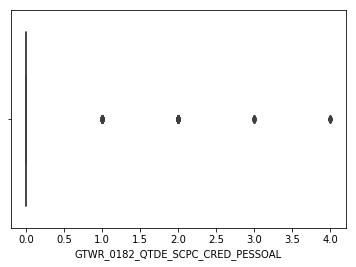

In [98]:
sns.boxplot(dados['GTWR_0182_QTDE_SCPC_CRED_PESSOAL'])

In [99]:
dados[dados['GTWR_0182_QTDE_SCPC_CRED_PESSOAL'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_PESSOAL
FLG_NAOPAGOU,
0,644
1,54


In [100]:
dados[['CPF', 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL']].groupby('GTWR_0182_QTDE_SCPC_CRED_PESSOAL').count()

,CPF
GTWR_0182_QTDE_SCPC_CRED_PESSOAL,
0.000000,78911
1.000000,610
2.000000,75
3.000000,8
4.000000,5


In [101]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['GTWR_0182_QTDE_SCPC_CRED_PESSOAL'] > 0][['FLG_NAOPAGOU', 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL']].groupby('FLG_NAOPAGOU').count()

,GTWR_0182_QTDE_SCPC_CRED_PESSOAL
FLG_NAOPAGOU,
0,644
1,54


In [102]:
def registroCreditoPessoal(x):
    if x == 0:
        return 'NAO'
    elif x >= 1:
        return 'SIM'
    else:
        return None

## TODO: avaliar se não é melhor manter as quantidades e utilizar a feature como quantitativa discreta

In [103]:
dados['TEVE_REG_CREDITO_PESSOAL'] = dados['GTWR_0182_QTDE_SCPC_CRED_PESSOAL'].apply(registroCreditoPessoal)

In [104]:
dados.shape

(232125, 69)

In [105]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['TEVE_REG_CREDITO_PESSOAL'] == 'SIM'][['FLG_NAOPAGOU', 'TEVE_REG_CREDITO_PESSOAL']].groupby('FLG_NAOPAGOU').count()

,TEVE_REG_CREDITO_PESSOAL
FLG_NAOPAGOU,
0,644
1,54


In [106]:
#dados = dados.drop('GTWR_0182_QTDE_SCPC_CRED_PESSOAL', axis=1)

In [107]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_CRED_VEICULOS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.000917,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.032663,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,3.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


In [108]:
dados[['CPF', 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS']].groupby('GTWR_0182_QTDE_SCPC_CRED_VEICULOS').count()

,CPF
GTWR_0182_QTDE_SCPC_CRED_VEICULOS,
0.000000,79541
1.000000,64
2.000000,3
3.000000,1


In [109]:
dados = dados.drop('GTWR_0182_QTDE_SCPC_CRED_VEICULOS', axis=1)

In [110]:
dados[['CPF', 'GTWR_0182_QTDE_SCPC_OUTROS']].groupby('GTWR_0182_QTDE_SCPC_OUTROS').count()

,CPF
GTWR_0182_QTDE_SCPC_OUTROS,
0.000000,74170
1.000000,3706
2.000000,1444
3.000000,233
4.000000,46
5.000000,9
7.000000,1


In [111]:
def registroOutros(x):
    if x == 0:
        return 'NAO'
    elif x >= 1:
        return 'SIM'
    else:
        return None

## TODO: avaliar se não é melhor manter as quantidades e utilizar a feature como quantitativa discreta

In [112]:
dados['TEVE_REG_OUTROS'] = dados['GTWR_0182_QTDE_SCPC_OUTROS'].apply(registroOutros)

In [113]:
dados.shape

(232125, 69)

In [114]:
# Das observações que foram registradas mais de uma vez pelo motivo de cartão de crédito, 212 viraram FPD
dados[dados['TEVE_REG_OUTROS'] == 'SIM'][['FLG_NAOPAGOU', 'TEVE_REG_OUTROS']].groupby('FLG_NAOPAGOU').count()

,TEVE_REG_OUTROS
FLG_NAOPAGOU,
0,5352
1,87


In [115]:
#dados = dados.drop('GTWR_0182_QTDE_SCPC_OUTROS', axis=1)

In [116]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.094575,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.386255,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


In [117]:
dados[['CPF', 'GTWR_0182_QTDE_SCPC_TOT_PSGS']].groupby('GTWR_0182_QTDE_SCPC_TOT_PSGS').count()

,CPF
GTWR_0182_QTDE_SCPC_TOT_PSGS,
0.000000,63234
1.000000,11276
2.000000,3518
3.000000,1058
4.000000,343
5.000000,112
6.000000,44
7.000000,19
8.000000,2


In [118]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,...,GTWR_0304_CHQ_FND_BACEN_QTDE_,GTWR_0304_PENDS_FINS_QTDE_,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,...,214979.000000,214979.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.094575,...,0.022607,-0.004754,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.386255,...,0.428432,0.176922,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,...,34.000000,54.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


In [119]:
dados[['CPF', 'GTWR_0304_CHQ_FND_BACEN_QTDE_']].groupby('GTWR_0304_CHQ_FND_BACEN_QTDE_').count()

,CPF
GTWR_0304_CHQ_FND_BACEN_QTDE_,
0.000000,213550
1.000000,608
2.000000,272
3.000000,147
4.000000,83
5.000000,79
6.000000,38
7.000000,34
8.000000,34


In [120]:
dados[['CPF', 'GTWR_0304_PENDS_FINS_QTDE_']].groupby('GTWR_0304_PENDS_FINS_QTDE_').count()

,CPF
GTWR_0304_PENDS_FINS_QTDE_,
-1.000000,1534
0.000000,213197
1.000000,161
2.000000,45
3.000000,22
4.000000,8
5.000000,3
6.000000,2
7.000000,1


In [121]:
dados = dados.drop(['GTWR_0304_CHQ_FND_BACEN_QTDE_', 'GTWR_0304_PENDS_FINS_QTDE_'], axis=1)

In [122]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,GTWR_0304_PENDS_FINS_VL_TOT_,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,79609.000000,214979.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.094575,0.299815,2.161280,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.386255,0.701130,327.985573,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,1.000000,2.000000,-1.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,64128.050000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


In [123]:
dados[['GTWR_0304_PENDS_FINS_VL_TOT_']].describe(percentiles=[.25, .50, .75, .9, .95, .98, .99])

,GTWR_0304_PENDS_FINS_VL_TOT_
count,214979.000000
mean,2.161280
std,327.985573
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
90%,-1.000000
95%,-1.000000
98%,-1.000000


In [124]:
dados = dados.drop('GTWR_0304_PENDS_FINS_VL_TOT_', axis=1)

In [125]:
dados.describe(percentiles=[.25, .50, .75, .9, .95])

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,232125.000000,79609.000000,79609.000000,79609.000000,79609.000000,79609.000000,222168.000000,232125.000000,222168.000000,221935.000000,232125.000000,232125.000000,232125.000000
mean,27700112300.663147,3.820549,11.941161,0.000345,0.000763,609.002257,0.036290,0.157683,0.010099,0.094575,0.299815,9236612.230564,27700112300.663147,1821.186812,678.815694,0.035386,0.244252,0.289952
std,20893939757.139442,5.170949,9.007130,0.020960,0.036121,291.427806,0.210223,0.477743,0.115058,0.386255,0.701130,5848845.426858,20893939757.139442,22219.149780,155.504969,0.184754,0.429644,0.453741
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11606909878.000000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6260120.000000,11606909878.000000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26516955808.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8527055.000000,26516955808.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36184613804.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11925000.000000,36184613804.000000,2000.000000,796.000000,0.000000,0.000000,1.000000
90%,49895358723.400002,10.000000,25.000000,0.000000,0.000000,900.000000,0.000000,1.000000,0.000000,0.000000,1.000000,13225505.000000,49895358723.400002,2600.000000,864.000000,0.000000,1.000000,1.000000
95%,76759579649.599991,16.000000,30.000000,0.000000,0.000000,1170.000000,0.000000,1.000000,0.000000,1.000000,2.000000,13632395.000000,76759579649.599991,3072.795000,896.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,99709522.000000,99996359891.000000,10003000.000000,999.000000,1.000000,1.000000,1.000000


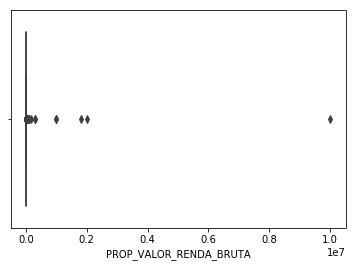

In [126]:
sns.boxplot(dados['PROP_VALOR_RENDA_BRUTA'])

In [127]:
dados['PROP_VALOR_RENDA_BRUTA'] = (dados['PROP_VALOR_RENDA_BRUTA'].replace(',','.', regex=True).astype(float))

In [128]:
dados[['PROP_VALOR_RENDA_BRUTA']].describe(percentiles=[.25, .50, .75, .9, .95, .98, .99])

,PROP_VALOR_RENDA_BRUTA
count,222168.000000
mean,1821.186812
std,22219.149780
min,678.790000
25%,1200.000000
50%,1500.000000
75%,2000.000000
90%,2600.000000
95%,3072.795000
98%,4500.000000


In [129]:
dados[dados['PROP_VALOR_RENDA_BRUTA'] > 5000][['CPF', 'PROP_VALOR_RENDA_BRUTA', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

,CPF,PROP_VALOR_RENDA_BRUTA
FLG_NAOPAGOU,,
0,1815,1815
1,25,25


In [130]:
dados[(dados['PROP_VALOR_RENDA_BRUTA'] > 5000) & (dados['FLG_NAOPAGOU'] == 1)] 

,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA,TEVE_REG_CARTAO_CREDITO,TEVE_REG_CREDITO_DIRETO,TEVE_REG_CREDITO_PESSOAL,TEVE_REG_OUTROS
62,41424958873,M,0,5,Até 2º grau completo,Solteiro,AUTÔNOMO,Alugada,Autônomo,0,...,NaN,NaN,486.000000,1,0,0,NAO,SIM,NAO,SIM
136,18915107896,M,3,20,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,S,S,676.000000,1,0,1,NAO,NAO,NAO,NAO
415,36498783800,F,2,10,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,N,NaN,571.000000,1,0,1,NAO,NAO,NAO,NAO
506,38114952830,M,14,20,Até 2º grau completo,Casado,VENDEDOR AUTÔNOMO / AMBULANTE / CAMELÔ / SACOL...,Própria,Autônomo,0,...,N,NaN,612.000000,1,0,1,NAO,SIM,NAO,SIM
2315,14781945880,M,0,15,Até 2º grau completo,Casado,AUTÔNOMO,Própria,Autônomo,0,...,N,NaN,620.000000,1,0,1,NAO,NAO,NAO,NAO
3439,27257821801,F,6,13,Até 2º grau completo,Casado,AUTÔNOMO,Própria,Autônomo,0,...,N,NaN,561.000000,1,0,0,None,None,None,None
3891,34773933844,F,5,1,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,N,NaN,603.000000,1,0,0,None,None,None,None
3952,27175569823,F,0,25,Até 2º grau completo,Casado,OUTROS,Própria,Autônomo,0,...,N,NaN,775.000000,1,0,0,None,None,None,None
4051,22207064867,M,0,1,Superior (Completo),Casado,COMERCIÁRIO EM GERAL,Própria,Autônomo,0,...,NaN,NaN,532.000000,1,0,0,None,None,None,None
4502,20006119824,M,20,4,Até 2º grau completo,Casado,OUTROS,Própria,Empregado,0,...,NaN,NaN,702.000000,1,0,0,None,None,None,None


In [131]:
dados[(dados['PROP_VALOR_RENDA_BRUTA'] < 5000)].describe()

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,218607.000000,218607.000000,218607.000000,218607.000000,218607.000000,218607.000000,78462.000000,78462.000000,78462.000000,78462.000000,78462.000000,218607.000000,218607.000000,218607.000000,218374.000000,218607.000000,218607.000000,218607.000000
mean,27735611829.147034,3.780716,11.914362,0.000334,0.000764,601.124717,0.036323,0.157822,0.009877,0.092006,0.297188,9235373.768717,27735611829.147034,1671.457804,678.214948,0.035799,0.255143,0.303334
std,20848467133.136803,5.084568,8.991090,0.020844,0.036225,286.886142,0.210435,0.478048,0.111951,0.380788,0.698088,5794664.000802,20848467133.136803,662.133912,155.522048,0.185790,0.435942,0.459699
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11649207846.500000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6270320.000000,11649207846.500000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26597552806.000000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8532410.000000,26597552806.000000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36246013844.000000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11930000.000000,36246013844.000000,2000.000000,795.000000,0.000000,1.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,99709522.000000,99996359891.000000,4998.560000,999.000000,1.000000,1.000000,1.000000


In [132]:
dados['PROP_VALOR_RENDA_BRUTA'] = dados['PROP_VALOR_RENDA_BRUTA'].fillna(dados['PROP_VALOR_RENDA_BRUTA'].mean())

In [133]:
dados[(dados['PROP_VALOR_RENDA_BRUTA'] == 10003000)]['PROP_VALOR_RENDA_BRUTA']

9018   10003000.000000
Name: PROP_VALOR_RENDA_BRUTA, dtype: float64

In [134]:
dados[dados['PROP_VALOR_RENDA_BRUTA'] > 10000].groupby('FLG_NAOPAGOU').count()

,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,RGR_RI_DDD_CLI_IGUAL_UF_RES,RGR_THSYSTEM_CEP_CONFERE,RGR_THSYSTEM_END_CONFERE,SCORE_BV,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA,TEVE_REG_CARTAO_CREDITO,TEVE_REG_CREDITO_DIRETO,TEVE_REG_CREDITO_PESSOAL,TEVE_REG_OUTROS
FLG_NAOPAGOU,,,,,,,,,,,,,,,,,,,,,
0,171,171,171,171,171,171,171,171,171,171,...,171,97,21,171,171,171,55,55,55,55
1,2,2,2,2,2,2,2,2,2,2,...,2,2,0,2,2,2,1,1,1,1


In [135]:
dados = dados[dados['PROP_VALOR_RENDA_BRUTA'] <= 10000]

In [136]:
dados.shape

(231952, 66)

In [137]:
dados.describe()

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA
count,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,79553.000000,79553.000000,79553.000000,79553.000000,79553.000000,221995.000000,231952.000000,231952.000000,221762.000000,231952.000000,231952.000000,231952.000000
mean,27699978553.533092,3.817695,11.941117,0.000345,0.000763,608.957978,0.036303,0.157643,0.010094,0.094390,0.299599,9234328.253384,27699978553.533092,1740.102822,678.784729,0.035404,0.244214,0.289969
std,20891551803.307587,5.165563,9.006700,0.020967,0.036135,291.425579,0.210267,0.477732,0.115045,0.385923,0.701013,5833501.360620,20891551803.307587,837.524946,155.516383,0.184799,0.429621,0.453749
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000
25%,11608065802.250000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6260170.000000,11608065802.250000,1200.000000,579.000000,0.000000,0.000000,0.000000
50%,26518399357.500000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8527090.000000,26518399357.500000,1500.000000,684.000000,0.000000,0.000000,0.000000
75%,36185360104.750000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11925000.000000,36185360104.750000,2000.000000,796.000000,0.000000,0.000000,1.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,99709522.000000,99996359891.000000,10000.000000,999.000000,1.000000,1.000000,1.000000


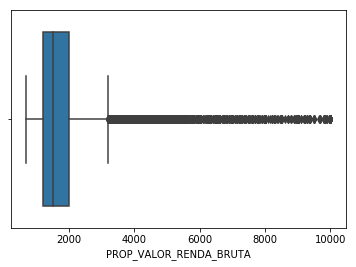

In [138]:
sns.boxplot(dados['PROP_VALOR_RENDA_BRUTA'])

In [139]:
outliers = outliersIndexes(dados['PROP_VALOR_RENDA_BRUTA'])

In [140]:
len(outliers[0])

9994

In [141]:
dados.loc[outliers][['PROP_VALOR_RENDA_BRUTA', 'FLG_NAOPAGOU']].groupby('FLG_NAOPAGOU').count()

C:\Users\joaoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,PROP_VALOR_RENDA_BRUTA
FLG_NAOPAGOU,
0.000000,9754
1.000000,174


### Utilizo técnica de discretização de variável para gerar as faixas de renda devido os outliers

In [142]:
faixaRendaBruta = np.digitize(dados['PROP_VALOR_RENDA_BRUTA'], bins=[1199.99, 1999.99])

In [143]:
dados['FAIXA_RENDA_BRUTA'] = faixaRendaBruta

In [144]:
dados[['CPF', 'PROP_VALOR_RENDA_BRUTA', 'FAIXA_RENDA_BRUTA']].head()

,CPF,PROP_VALOR_RENDA_BRUTA,FAIXA_RENDA_BRUTA
0,35503764803,1200.000000,1
1,26757814870,2190.000000,2
2,40837123844,1500.000000,1
3,35955698817,1500.000000,1
4,34465033826,1000.000000,0


In [145]:
quanti.remove('PROP_VALOR_RENDA_BRUTA')

In [146]:
quali.append('FAIXA_RENDA_BRUTA')

In [147]:
dados.describe()

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,PROP_CEP_RESIDENCIAL,PROP_CPF_TITULAR,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA,FAIXA_RENDA_BRUTA
count,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,79553.000000,79553.000000,79553.000000,79553.000000,79553.000000,221995.000000,231952.000000,231952.000000,221762.000000,231952.000000,231952.000000,231952.000000,231952.000000
mean,27699978553.533092,3.817695,11.941117,0.000345,0.000763,608.957978,0.036303,0.157643,0.010094,0.094390,0.299599,9234328.253384,27699978553.533092,1740.102822,678.784729,0.035404,0.244214,0.289969,1.090514
std,20891551803.307587,5.165563,9.006700,0.020967,0.036135,291.425579,0.210267,0.477732,0.115045,0.385923,0.701013,5833501.360620,20891551803.307587,837.524946,155.516383,0.184799,0.429621,0.453749,0.684658
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181200.000000,678.790000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,11608065802.250000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6260170.000000,11608065802.250000,1200.000000,579.000000,0.000000,0.000000,0.000000,1.000000
50%,26518399357.500000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8527090.000000,26518399357.500000,1500.000000,684.000000,0.000000,0.000000,0.000000,1.000000
75%,36185360104.750000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11925000.000000,36185360104.750000,2000.000000,796.000000,0.000000,0.000000,1.000000,2.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,99709522.000000,99996359891.000000,10000.000000,999.000000,1.000000,1.000000,1.000000,2.000000


In [148]:
dadosMissing(dados)

CASE_SCORE_X_LOJA - object:        12501
FLX_ACSP_VERIFICACAO_END - object:        15646
FLX_ANATEL - object:        15655
FLX_BOAVISTANET - object:        138432
FLX_IRPF - object:        15655
FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
GTWR_0182_QTDE_SCPC_TOT_PSGS - float64:        152399
PROP_CEP_RESIDENCIAL - float64:        9957
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        1

In [149]:
quanti

['CPF',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'VLR_ENTRADA',
 'LIMITE',
 'DIAS_ATRASO',
 'GTWR_0021_STATUS',
 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS',
 'GTWR_0182_QTDE_OUT_ATV_ECS',
 'GTWR_0182_QTDE_REGISTRADO',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_CHQ',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'GTWR_0304_CHQ_FND_BACEN_QTDE_',
 'GTWR_0304_PENDS_FINS_QTDE_',
 'GTWR_0304_PENDS_FINS_VL_TOT_',
 'PROP_CPF_TITULAR',
 'SCORE_BV']

In [150]:
dados['PROP_CEP_RESIDENCIAL'].head()

0   6340180.000000
1   8850090.000000
2   9332100.000000
3   6655620.000000
4   4857190.000000
Name: PROP_CEP_RESIDENCIAL, dtype: float64

In [151]:
dados['PROP_CEP_RESIDENCIAL'] = dados.PROP_CEP_RESIDENCIAL.apply(lambda x: '{0:0>10}'.format(x))

In [152]:
dados['PROP_CEP_RESIDENCIAL'].head(10)

0    06340180.0
1    08850090.0
2    09332100.0
3    06655620.0
4    04857190.0
5    04159070.0
6    06395320.0
7    08790340.0
8    02991040.0
9    11668410.0
Name: PROP_CEP_RESIDENCIAL, dtype: object

In [153]:
dados['CEP3'] = dados['PROP_CEP_RESIDENCIAL'].str[0:4]

In [154]:
dados[['CEP3', 'PROP_CEP_RESIDENCIAL']].head()

,CEP3,PROP_CEP_RESIDENCIAL
0,0634,06340180.0
1,0885,08850090.0
2,0933,09332100.0
3,0665,06655620.0
4,0485,04857190.0


In [155]:
dados = dados.drop('PROP_CEP_RESIDENCIAL', axis=1)

In [156]:
quanti

['CPF',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'VLR_ENTRADA',
 'LIMITE',
 'DIAS_ATRASO',
 'GTWR_0021_STATUS',
 'GTWR_0182_QTDE_OCRS_DEB_TITS_PROTS',
 'GTWR_0182_QTDE_OUT_ATV_ECS',
 'GTWR_0182_QTDE_REGISTRADO',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_CHQ',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_CRED_VEICULOS',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'GTWR_0304_CHQ_FND_BACEN_QTDE_',
 'GTWR_0304_PENDS_FINS_QTDE_',
 'GTWR_0304_PENDS_FINS_VL_TOT_',
 'PROP_CPF_TITULAR',
 'SCORE_BV']

In [157]:
list(dados)

['CPF',
 'SEXO',
 'TEMPOEMPREGADO',
 'TEMPOMORADIAANOS',
 'ESCOLARIDADE',
 'ESTADOCIVIL',
 'PROFISSAO',
 'MORADIA',
 'OCUPACAO',
 'NUM_DEPENDENTES',
 'NUM_FILHOS',
 'POSSUIVEICULO',
 'DATACADASTRO',
 'LIMITE',
 'CASE_SCORE_X_LOJA',
 'FLX_ACSP_VERIFICACAO_END',
 'FLX_ANATEL',
 'FLX_BOAVISTANET',
 'FLX_IRPF',
 'FLX_PRINCIPAL',
 'FLX_RECEITA_FEDERAL_PF',
 'FLX_RESTRICAO_INTERNA',
 'GTWR_0001_SITUACAO_CADASTRAL',
 'GTWR_0021_SITUACAO_DECLARACAO',
 'GTWR_0021_TEM_DEBS',
 'GTWR_0021_TEM_RESTITUICAO',
 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS',
 'GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO',
 'GTWR_0182_QTDE_SCPC_CRED_DIRETO',
 'GTWR_0182_QTDE_SCPC_CRED_PESSOAL',
 'GTWR_0182_QTDE_SCPC_OUTROS',
 'GTWR_0182_QTDE_SCPC_TOT_PSGS',
 'PROP_CPF_TITULAR',
 'PROP_DATA_NASCIMENTO_TITULAR',
 'PROP_VALOR_RENDA_BRUTA',
 'RGR_ACSP_CADASTRO_LOCALIZ',
 'RGR_ACSP_CEP_CONFERE',
 'RGR_ACSP_CPF_TEM_RESTRICAO',
 'RGR_ACSP_DOC_ROUBADO',
 'RGR_ACSP_DT_NASC_CONFERE',
 'RGR_ACSP_DT_NASC_EXISTE',
 'RGR_ACSP_NOME_MAE_EXISTE',
 'R

In [158]:
quali.remove('PROP_CEP_RESIDENCIAL')

In [159]:
dados = dados.drop('PROP_CPF_TITULAR', axis=1)

In [160]:
quanti, quali = tiposDeDados(dados)

In [161]:
dados[quanti].describe()

,CPF,TEMPOEMPREGADO,TEMPOMORADIAANOS,NUM_DEPENDENTES,NUM_FILHOS,LIMITE,GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO,GTWR_0182_QTDE_SCPC_CRED_DIRETO,GTWR_0182_QTDE_SCPC_CRED_PESSOAL,GTWR_0182_QTDE_SCPC_OUTROS,GTWR_0182_QTDE_SCPC_TOT_PSGS,PROP_VALOR_RENDA_BRUTA,SCORE_BV,FLG_NAOPAGOU,NOME_IGUAL_RECEITA,NOME_IGUAL_BOAVISTA,FAIXA_RENDA_BRUTA
count,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,231952.000000,79553.000000,79553.000000,79553.000000,79553.000000,79553.000000,231952.000000,221762.000000,231952.000000,231952.000000,231952.000000,231952.000000
mean,27699978553.533092,3.817695,11.941117,0.000345,0.000763,608.957978,0.036303,0.157643,0.010094,0.094390,0.299599,1740.102822,678.784729,0.035404,0.244214,0.289969,1.090514
std,20891551803.307587,5.165563,9.006700,0.020967,0.036135,291.425579,0.210267,0.477732,0.115045,0.385923,0.701013,837.524946,155.516383,0.184799,0.429621,0.453749,0.684658
min,181200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,678.790000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,11608065802.250000,0.000000,5.000000,0.000000,0.000000,440.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.000000,579.000000,0.000000,0.000000,0.000000,1.000000
50%,26518399357.500000,2.000000,10.000000,0.000000,0.000000,570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1500.000000,684.000000,0.000000,0.000000,0.000000,1.000000
75%,36185360104.750000,6.000000,15.000000,0.000000,0.000000,780.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,796.000000,0.000000,0.000000,1.000000,2.000000
max,99996359891.000000,40.000000,49.000000,2.000000,4.000000,2000.000000,6.000000,14.000000,4.000000,7.000000,17.000000,10000.000000,999.000000,1.000000,1.000000,1.000000,2.000000


In [162]:
dadosMissing(dados[quanti])

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
GTWR_0182_QTDE_SCPC_TOT_PSGS - float64:        152399
SCORE_BV - float64:        10190


In [163]:
dados[['SCORE_BV']].describe()

,SCORE_BV
count,221762.000000
mean,678.784729
std,155.516383
min,-1.000000
25%,579.000000
50%,684.000000
75%,796.000000
max,999.000000


In [164]:
dados['SCORE_BV'] = dados['SCORE_BV'].fillna(dados['SCORE_BV'].mean())

In [165]:
dadosMissing(dados[quanti])

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
GTWR_0182_QTDE_SCPC_TOT_PSGS - float64:        152399


In [166]:
dados[['CPF','GTWR_0182_QTDE_SCPC_TOT_PSGS']].groupby('GTWR_0182_QTDE_SCPC_TOT_PSGS').count()

,CPF
GTWR_0182_QTDE_SCPC_TOT_PSGS,
0.000000,63202
1.000000,11261
2.000000,3510
3.000000,1057
4.000000,343
5.000000,112
6.000000,44
7.000000,19
8.000000,2


In [167]:
dados[['GTWR_0182_QTDE_SCPC_TOT_PSGS']].describe()

,GTWR_0182_QTDE_SCPC_TOT_PSGS
count,79553.000000
mean,0.299599
std,0.701013
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,17.000000


In [168]:
dados['GTWR_0182_QTDE_SCPC_TOT_PSGS'].mode()

0   0.000000
dtype: float64

In [169]:
# Opto por usar a moda para preencher os missings
dados['GTWR_0182_QTDE_SCPC_TOT_PSGS'] = dados['GTWR_0182_QTDE_SCPC_TOT_PSGS'].fillna(0)

In [170]:
dados[['GTWR_0182_QTDE_SCPC_TOT_PSGS']].describe()

,GTWR_0182_QTDE_SCPC_TOT_PSGS
count,231952.000000
mean,0.102754
std,0.434475
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,17.000000


In [171]:
dadosMissing(dados[quali])

CASE_SCORE_X_LOJA - object:        12501
FLX_ACSP_VERIFICACAO_END - object:        15646
FLX_ANATEL - object:        15655
FLX_BOAVISTANET - object:        138432
FLX_IRPF - object:        15655
FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        

In [172]:
dados[['CPF', 'CASE_SCORE_X_LOJA']].groupby('CASE_SCORE_X_LOJA').count()

,CPF
CASE_SCORE_X_LOJA,
A,132997
B,22556
B-,23662
C,18305
D,10848
D-,7554
E,121
F,3408


In [173]:
scale_mapper = {'F': 1,
                'E': 1,
                'D-': 1.5,
                'D': 2,
                'C': 3,
                'B-': 3.5,
                'B': 4,
                'A': 5}

In [174]:
dados['ENC_CASE_SCORE_X_LOJA'] = dados['CASE_SCORE_X_LOJA'].replace(scale_mapper)

In [175]:
dados[['CASE_SCORE_X_LOJA', 'ENC_CASE_SCORE_X_LOJA']].head()

,CASE_SCORE_X_LOJA,ENC_CASE_SCORE_X_LOJA
0,C,3.000000
1,B-,3.500000
2,B-,3.500000
3,D-,1.500000
4,B,4.000000


In [176]:
dados[['SCORE_BV', 'ENC_CASE_SCORE_X_LOJA']].corr()

,SCORE_BV,ENC_CASE_SCORE_X_LOJA
SCORE_BV,1.000000,0.803230
ENC_CASE_SCORE_X_LOJA,0.803230,1.000000


## Ficou confirmado que há uma relação linear positiva entre o Score Boa Vista, logo, foi possível tratar a variável categórica como qualitativa ordinal

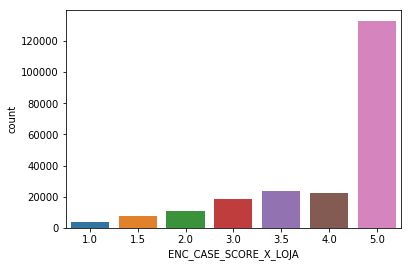

In [177]:
sns.countplot(dados['ENC_CASE_SCORE_X_LOJA'])

In [178]:
dados['ENC_CASE_SCORE_X_LOJA'].describe()

count   219451.000000
mean         4.235556
std          1.103870
min          1.000000
25%          3.500000
50%          5.000000
75%          5.000000
max          5.000000
Name: ENC_CASE_SCORE_X_LOJA, dtype: float64

In [179]:
dados['ENC_CASE_SCORE_X_LOJA'].mode()

0   5.000000
dtype: float64

In [180]:
dados['ENC_CASE_SCORE_X_LOJA'] = dados['ENC_CASE_SCORE_X_LOJA'].fillna(6)

In [181]:
dados['CASE_SCORE_X_LOJA'] = dados['CASE_SCORE_X_LOJA'].fillna('A')

In [182]:
dadosMissing(dados[quali])

FLX_ACSP_VERIFICACAO_END - object:        15646
FLX_ANATEL - object:        15655
FLX_BOAVISTANET - object:        138432
FLX_IRPF - object:        15655
FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        23057

In [183]:
dados[['CPF', 'FLX_ACSP_VERIFICACAO_END']].groupby('FLX_ACSP_VERIFICACAO_END').count()

,CPF
FLX_ACSP_VERIFICACAO_END,
SEGUIR - A,215681
SEGUIR - P,256
SEGUIR-ALM,369


In [184]:
scale_mapper = {'SEGUIR - A': 2,
                'SEGUIR-ALM': 3,
                'SEGUIR - P': 1}

In [185]:
dados['ENC_FLX_ACSP_VERIFICACAO_END'] = dados['FLX_ACSP_VERIFICACAO_END'].replace(scale_mapper)

In [186]:
dados[['SCORE_BV', 'ENC_FLX_ACSP_VERIFICACAO_END']].corr()

,SCORE_BV,ENC_FLX_ACSP_VERIFICACAO_END
SCORE_BV,1.000000,-0.045953
ENC_FLX_ACSP_VERIFICACAO_END,-0.045953,1.000000


In [187]:
dados = dados.drop('ENC_FLX_ACSP_VERIFICACAO_END', axis=1)

In [188]:
dados['FLX_ACSP_VERIFICACAO_END'] = dados['FLX_ACSP_VERIFICACAO_END'].fillna('SEGUIR - A')

In [189]:
dados['ENC_FLX_ACSP_VERIFICACAO_END'] = dados['FLX_ACSP_VERIFICACAO_END'].replace(scale_mapper)

In [190]:
dadosMissing(dados[quali])

FLX_ANATEL - object:        15655
FLX_BOAVISTANET - object:        138432
FLX_IRPF - object:        15655
FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134


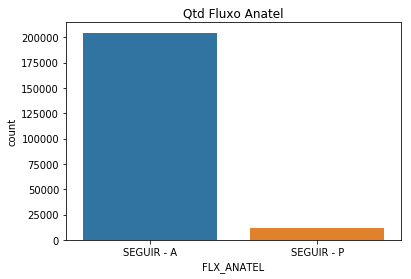

In [191]:
ax = sns.countplot(dados['FLX_ANATEL'])
ax.set_title('Qtd Fluxo Anatel')
plt.show()

In [192]:
dados['FLX_ANATEL'] = dados['FLX_ANATEL'].fillna('SEGUIR - A')

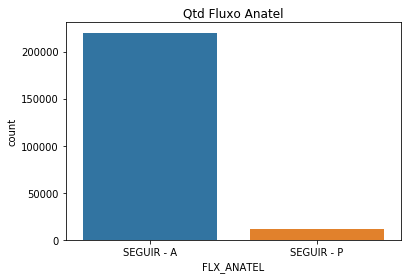

In [193]:
ax = sns.countplot(dados['FLX_ANATEL'])
ax.set_title('Qtd Fluxo Anatel')
plt.show()

In [194]:
scale_mapper = {'SEGUIR - A': 2,
                'SEGUIR - P': 1}

In [195]:
dados['ENC_FLX_ANATEL'] = dados['FLX_ANATEL'].replace(scale_mapper)

In [196]:
dados.shape

(231952, 69)

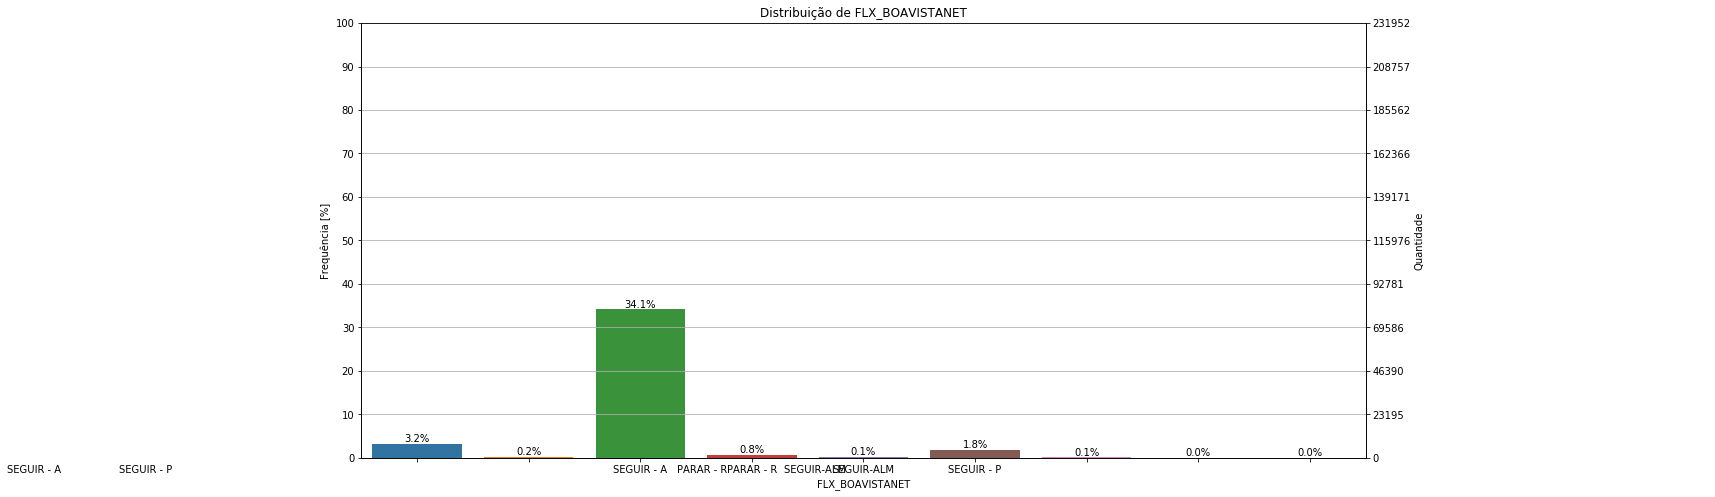

In [197]:
plotarFrequencia(dados, 'FLX_BOAVISTANET')

In [198]:
# Categorizando as variáveis missing - step functions
dados['FLX_BOAVISTANET'] = dados['FLX_BOAVISTANET'].fillna('MISSING')

In [199]:
dados[['CPF', 'FLX_BOAVISTANET']].groupby('FLX_BOAVISTANET').count()

,CPF
FLX_BOAVISTANET,
,2
MISSING,138432
PARAR - R,1784
PARAR - R,276
SEGUIR - A,79160
SEGUIR - A,7358
SEGUIR - P,4152
SEGUIR - P,434
SEGUIR-ALM,335


In [200]:
dados[dados['FLX_BOAVISTANET'] == 'SEGUIR - A                                                                                                                                                                                                                                                     '].head()

,CPF,SEXO,TEMPOEMPREGADO,TEMPOMORADIAANOS,ESCOLARIDADE,ESTADOCIVIL,PROFISSAO,MORADIA,OCUPACAO,NUM_DEPENDENTES,...,NOME_IGUAL_BOAVISTA,TEVE_REG_CARTAO_CREDITO,TEVE_REG_CREDITO_DIRETO,TEVE_REG_CREDITO_PESSOAL,TEVE_REG_OUTROS,FAIXA_RENDA_BRUTA,CEP3,ENC_CASE_SCORE_X_LOJA,ENC_FLX_ACSP_VERIFICACAO_END,ENC_FLX_ANATEL
5355,43150243840,F,0,1,Até 2º grau completo,Solteiro,AUX. DE ESCRIT. / VENDAS / ADMINIST. / ALMOXAR...,Própria,Autônomo,0,...,0,None,None,None,None,0,1146,3.500000,2,2
5356,13786448833,M,6,12,Até 2º grau completo,Casado,AUX. DE ESCRIT. / VENDAS / ADMINIST. / ALMOXAR...,Própria,Empregado,0,...,0,None,None,None,None,2,1322,3.500000,2,2
5357,16179148864,F,0,5,Superior (Completo),Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,0,None,None,None,None,1,1870,5.000000,2,2
5358,31552367878,M,0,10,Até 2º grau completo,Solteiro,GERENTE,Própria,Autônomo,0,...,0,None,None,None,None,0,0686,3.500000,2,2
5359,41732003823,M,7,10,Até 2º grau completo,Solteiro,AUTÔNOMO,Própria,Autônomo,0,...,0,None,None,None,None,1,0442,3.000000,2,2


In [201]:
dados['FLX_BOAVISTANET'].unique()

array(['MISSING',
       'SEGUIR - A                                                                                                                                                                                                                                                     ',
       'SEGUIR - P                                                                                                                                                                                                                                                     ',
       'SEGUIR - A', 'PARAR - R', 'SEGUIR-ALM', 'SEGUIR - P',
       'PARAR - R                                                                                                                                                                                                                                                      ',
       'SEGUIR-ALM                                                                                                        

In [202]:
dados_teste = dados.copy()

In [203]:
dados['FLX_BOAVISTANET'] = dados['FLX_BOAVISTANET'].apply(lambda x: x.strip())

In [204]:
dados[['CPF', 'FLX_BOAVISTANET']].groupby('FLX_BOAVISTANET').count()

,CPF
FLX_BOAVISTANET,
,2
MISSING,138432
PARAR - R,2060
SEGUIR - A,86518
SEGUIR - P,4586
SEGUIR-ALM,354


In [205]:
dados['FLX_BOAVISTANET'] = dados_teste['FLX_BOAVISTANET'].replace('', np.nan)

In [206]:
# Categorizando as variáveis missing - step functions
dados['FLX_BOAVISTANET'] = dados['FLX_BOAVISTANET'].fillna('MISSING')

In [207]:
dados[['CPF', 'FLX_BOAVISTANET']].groupby('FLX_BOAVISTANET').count()

,CPF
FLX_BOAVISTANET,
,2
MISSING,138432
PARAR - R,1784
PARAR - R,276
SEGUIR - A,79160
SEGUIR - A,7358
SEGUIR - P,4152
SEGUIR - P,434
SEGUIR-ALM,335


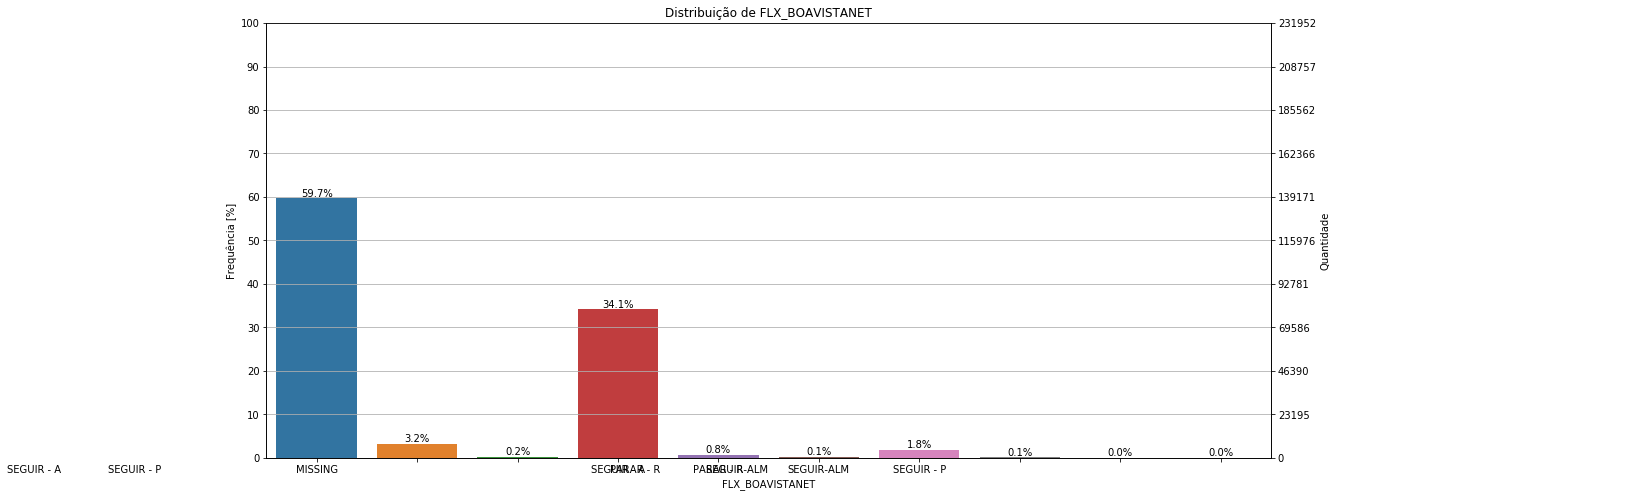

In [208]:
plotarFrequencia(dados, 'FLX_BOAVISTANET')

In [209]:
scale_mapper = {'SEGUIR - A': 4,
                'SEGUIR - ALM': 5,
                'SEGUIR - P': 3,
                'PARAR - R': 2,
                'MISSING': 1
            }

In [210]:
dados['ENC_FLX_BOAVISTANET'] = dados['FLX_BOAVISTANET'].replace(scale_mapper)

In [211]:
dadosMissing(dados[quali])

FLX_IRPF - object:        15655
FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPOND

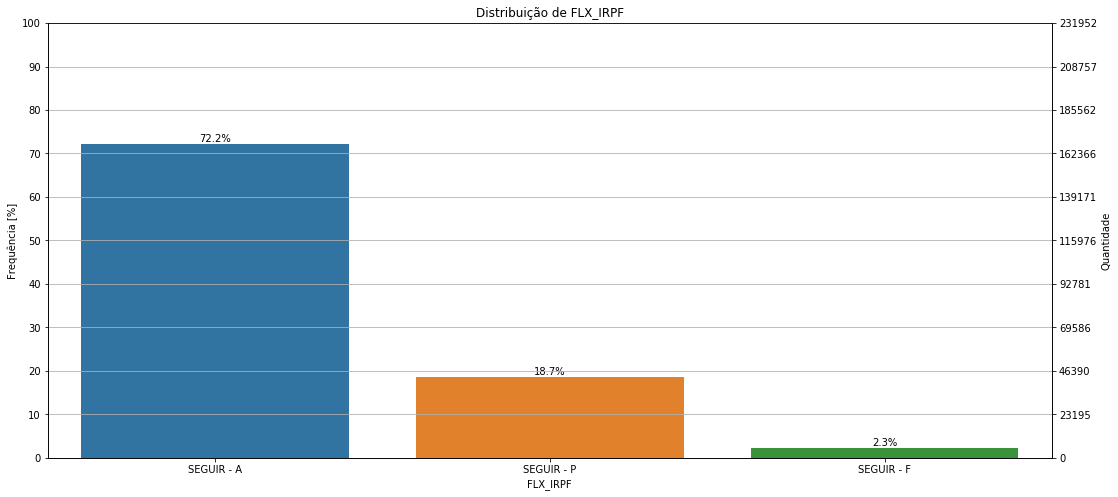

In [212]:
plotarFrequencia(dados, 'FLX_IRPF')

In [213]:
# Categorizando as variáveis missing - step function
dados['FLX_IRPF'] = dados['FLX_IRPF'].fillna('MISSING')

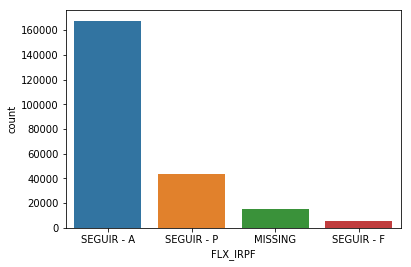

In [214]:
sns.countplot(dados['FLX_IRPF'])

In [215]:
scale_mapper = {'SEGUIR - A': 4,
                'SEGUIR - P': 3,
                'SEGUIR - F': 2,
                'MISSING': 1
            }

In [216]:
dados['ENC_FLX_IRPF'] = dados['FLX_IRPF'].replace(scale_mapper)

In [217]:
dadosMissing(dados[quali])

FLX_PRINCIPAL - object:        9957
FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT

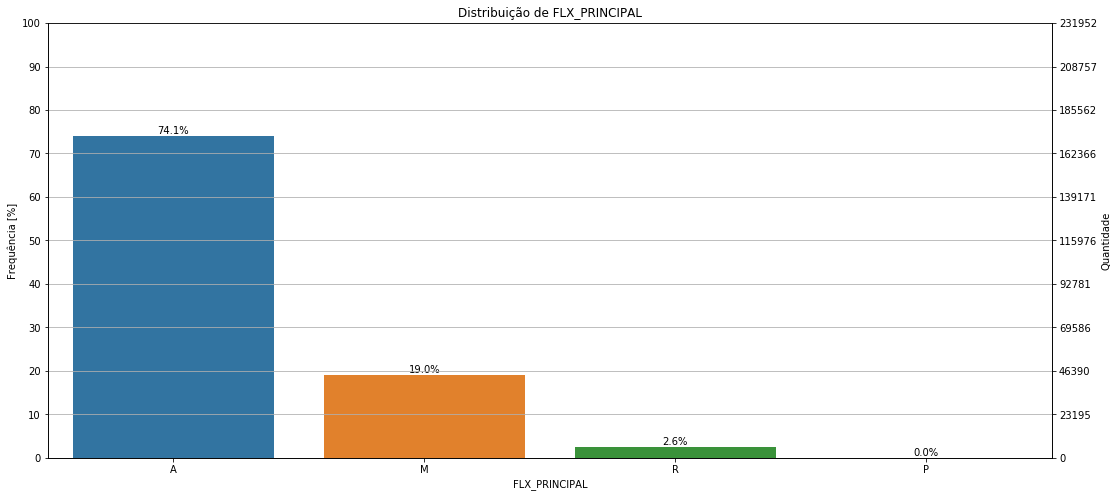

In [218]:
plotarFrequencia(dados, 'FLX_PRINCIPAL')

In [219]:
# Categorizando as variáveis missing - step function
dados['FLX_PRINCIPAL'] = dados['FLX_PRINCIPAL'].fillna('MISSING')

In [220]:
scale_mapper = {'A': 5,
                'M': 3,
                'P': 3,
                'R': 2,
                'MISSING': 1
            }

In [221]:
dados['ENC_FLX_PRINCIPAL'] = dados['FLX_PRINCIPAL'].replace(scale_mapper)

In [222]:
dadosMissing(dados[quali])

FLX_RECEITA_FEDERAL_PF - object:        9974
FLX_RESTRICAO_INTERNA - object:        11316
GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        

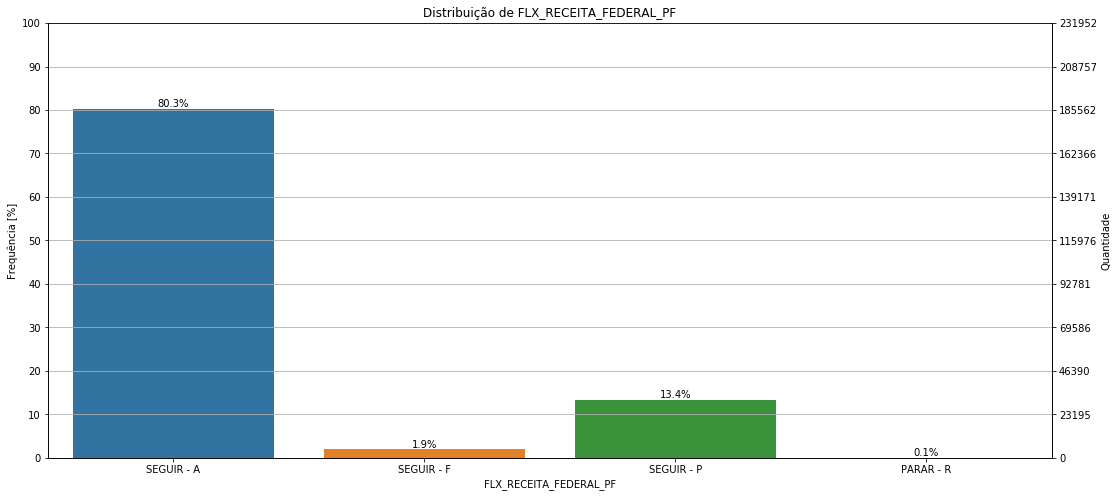

In [223]:
plotarFrequencia(dados, 'FLX_RECEITA_FEDERAL_PF')

In [224]:
# Categorizando as variáveis missing - step function
dados['FLX_RECEITA_FEDERAL_PF'] = dados['FLX_RECEITA_FEDERAL_PF'].fillna('MISSING')

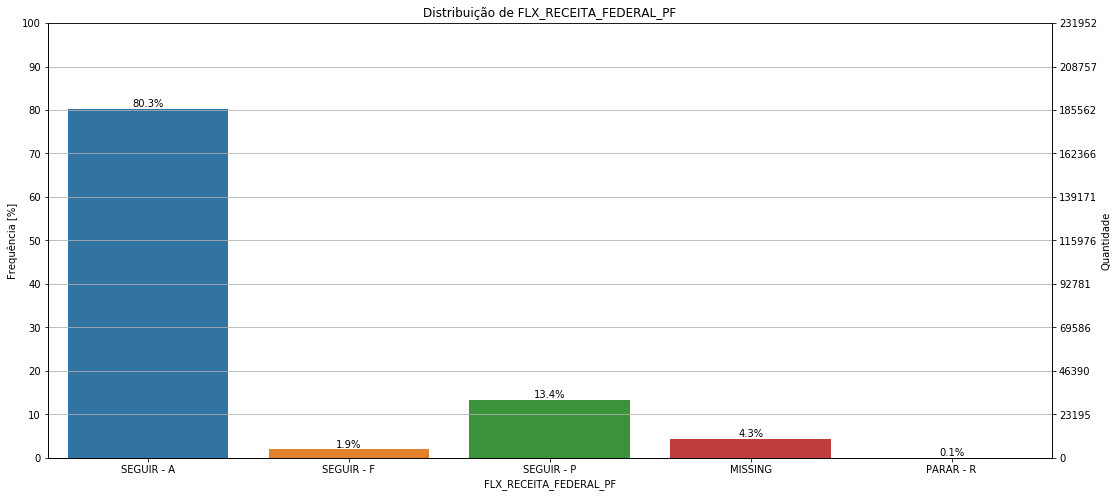

In [225]:
plotarFrequencia(dados, 'FLX_RECEITA_FEDERAL_PF')

In [226]:
scale_mapper = {'SEGUIR - A': 5,
                'SEGUIR - P': 4,
                'SEGUIR - F': 3,
                'PARAR - R': 2,
                'MISSING': 1
            }

In [227]:
dados['ENC_FLX_RECEITA_FEDERAL_PF'] = dados['FLX_RECEITA_FEDERAL_PF'].replace(scale_mapper)

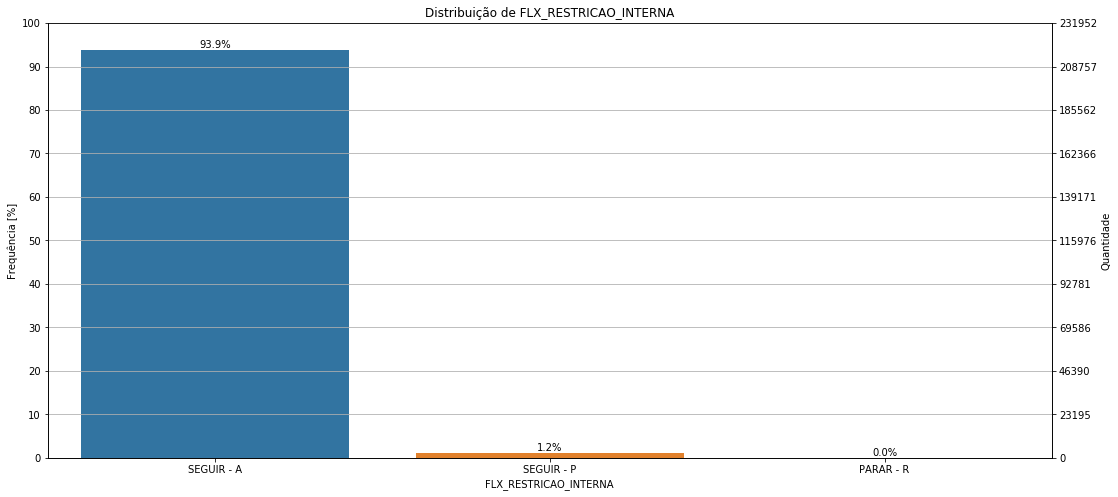

In [228]:
plotarFrequencia(dados, 'FLX_RESTRICAO_INTERNA')

In [229]:
# Categorizando as variáveis missing pela moda
dados['FLX_RESTRICAO_INTERNA'] = dados['FLX_RESTRICAO_INTERNA'].fillna('SEGUIR - A')

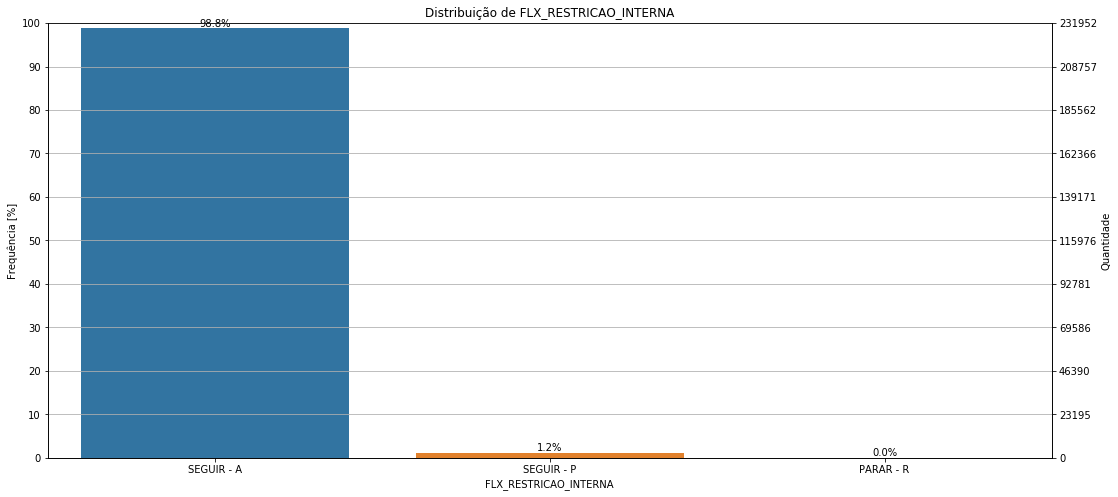

In [230]:
plotarFrequencia(dados, 'FLX_RESTRICAO_INTERNA')

In [231]:
scale_mapper = {'SEGUIR - A': 3,
                'SEGUIR - P': 2,
                'PARAR - R': 1
            }

In [232]:
dados['ENC_FLX_RESTRICAO_INTERNA'] = dados['FLX_RESTRICAO_INTERNA'].replace(scale_mapper)

In [233]:
dadosMissing(dados[quali])

GTWR_0001_SITUACAO_CADASTRAL - object:        23792
GTWR_0021_SITUACAO_DECLARACAO - object:        27134
GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        84893
RGR_NOME_MAE_CONFERE - object:        158011
RGR_RFPF_CPF_CANCELADO - object:       

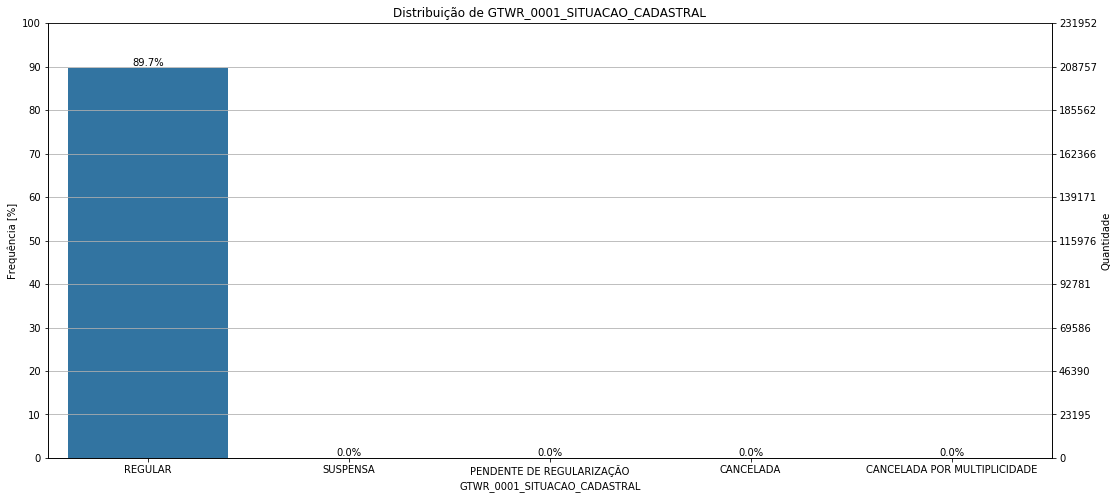

In [234]:
plotarFrequencia(dados, 'GTWR_0001_SITUACAO_CADASTRAL')

In [235]:
# Categorizando as variáveis missing pela moda
dados['GTWR_0001_SITUACAO_CADASTRAL'] = dados['GTWR_0001_SITUACAO_CADASTRAL'].fillna('REGULAR')

In [236]:
dummies = []
dummies.append('GTWR_0001_SITUACAO_CADASTRAL')

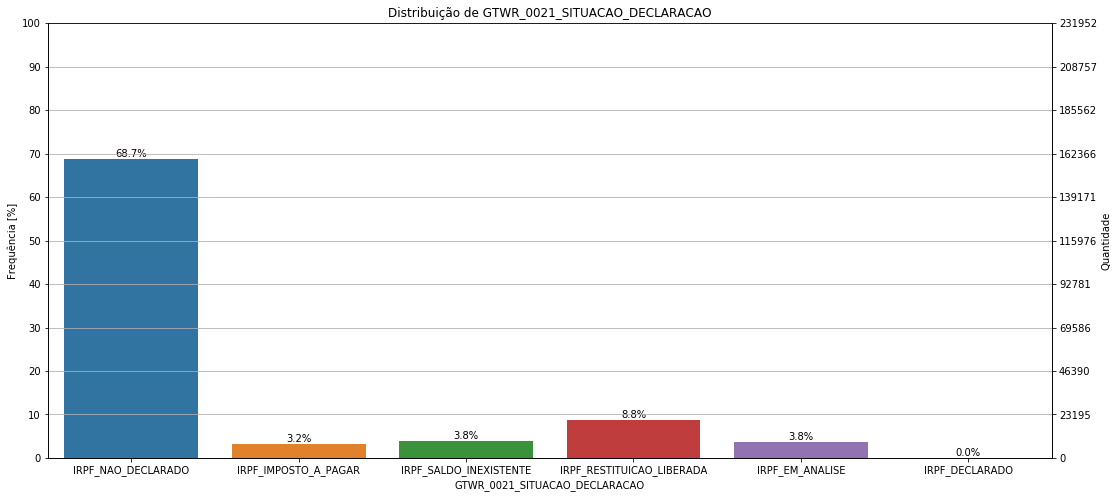

In [237]:
plotarFrequencia(dados, 'GTWR_0021_SITUACAO_DECLARACAO')

In [238]:
# Categorizando as variáveis missing com step funtcion
dados['GTWR_0021_SITUACAO_DECLARACAO'] = dados['GTWR_0021_SITUACAO_DECLARACAO'].fillna('MISSING')

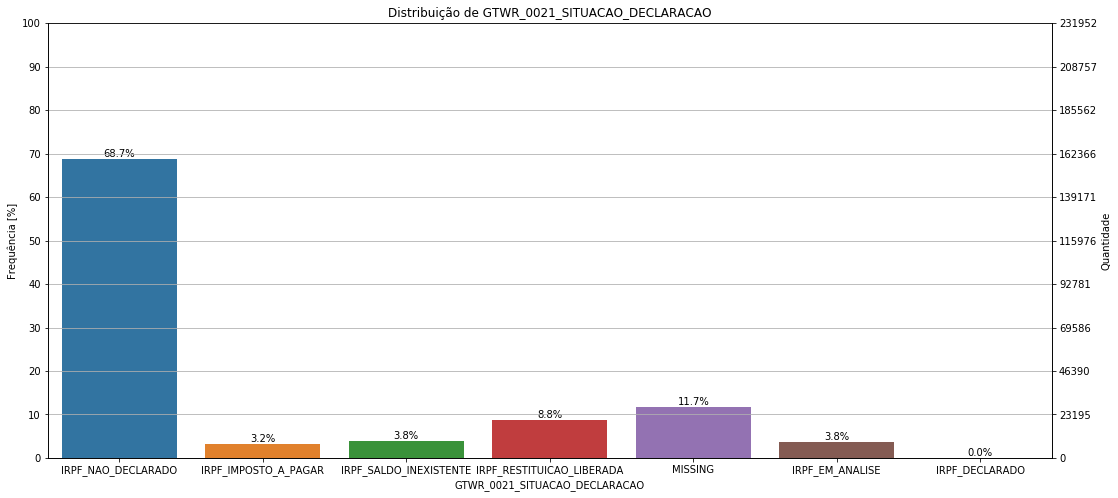

In [239]:
plotarFrequencia(dados, 'GTWR_0021_SITUACAO_DECLARACAO')

In [240]:
dummies.append('GTWR_0021_SITUACAO_DECLARACAO')

In [241]:
dadosMissing(dados[quali])

GTWR_0021_TEM_DEBS - object:        27134
GTWR_0021_TEM_RESTITUICAO - object:        27134
GTWR_0182_EXISTE_NDAC_DOCS_SOLICS - object:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        84893
RGR_NOME_MAE_CONFERE - object:        158011
RGR_RFPF_CPF_CANCELADO - object:        23932
RGR_RFPF_CPF_ENCONTRADO - object:        23769
RGR_RFPF_CPF_PENDENTE - object:        23792
RGR_RF

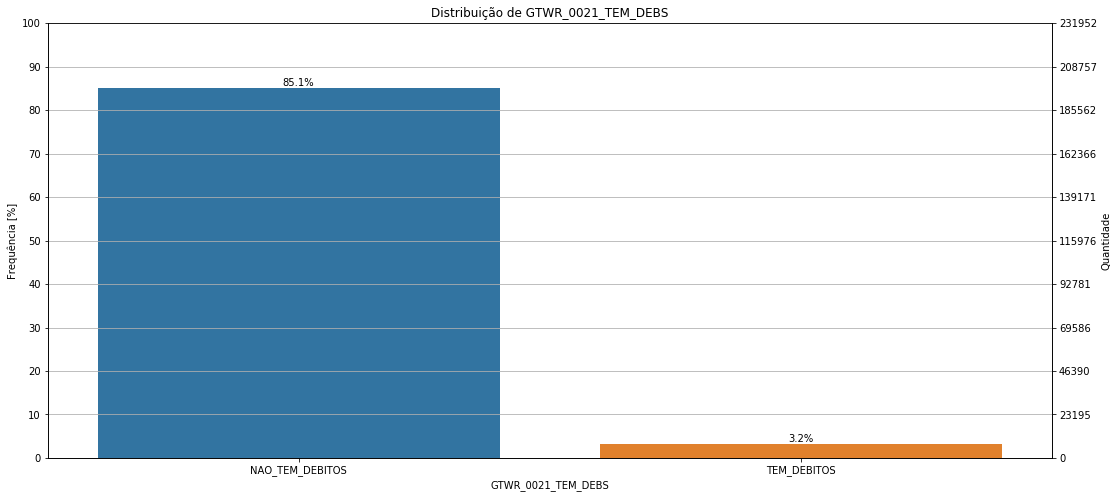

In [242]:
plotarFrequencia(dados, 'GTWR_0021_TEM_DEBS') #MCAR

In [243]:
# Categorizando as variáveis missing com step funtcion
dados['GTWR_0021_TEM_DEBS'] = dados['GTWR_0021_TEM_DEBS'].fillna('MISSING')

In [244]:
dummies.append('GTWR_0021_TEM_DEBS')

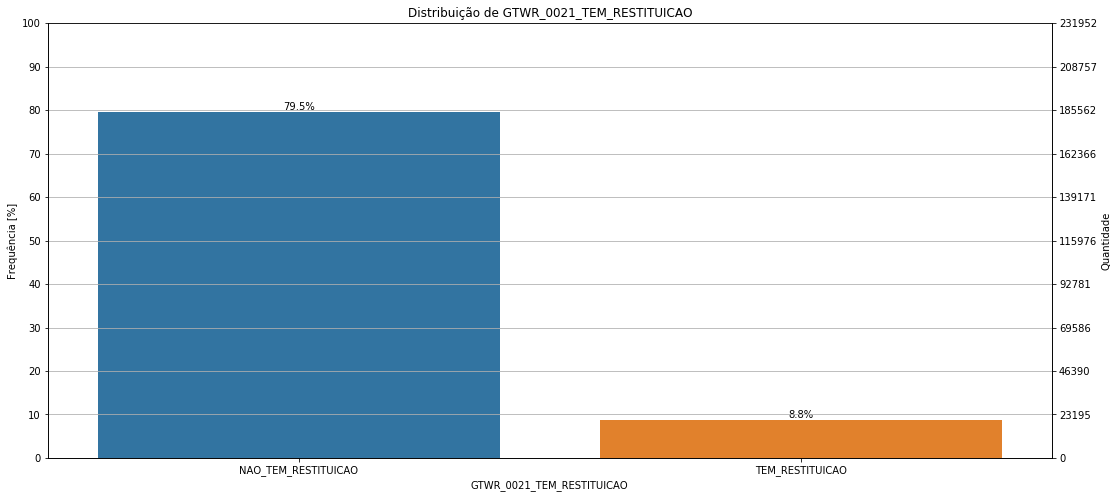

In [245]:
plotarFrequencia(dados, 'GTWR_0021_TEM_RESTITUICAO')

In [246]:
# Categorizando as variáveis missing com step funtcion
dados['GTWR_0021_TEM_RESTITUICAO'] = dados['GTWR_0021_TEM_RESTITUICAO'].fillna('MISSING')

In [247]:
dummies.append('GTWR_0021_TEM_RESTITUICAO')

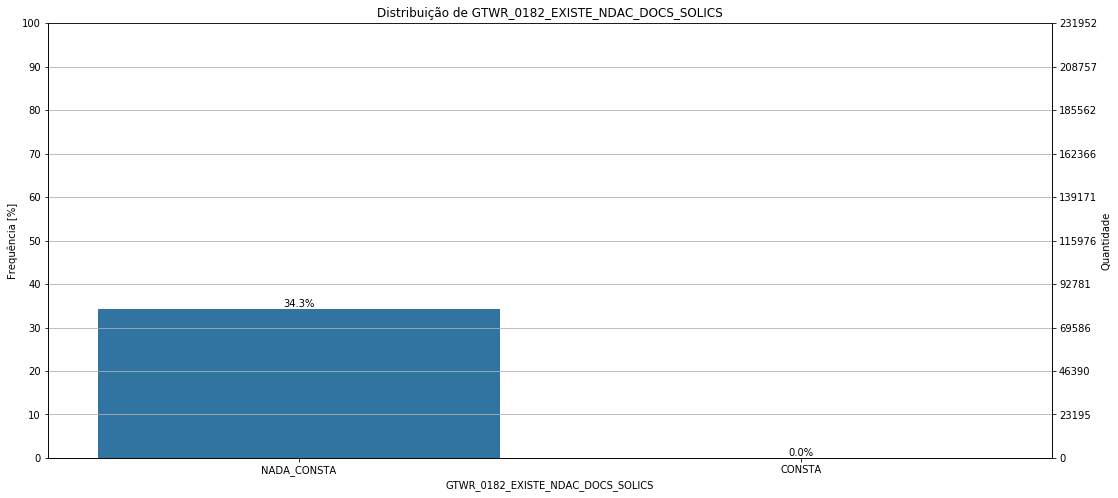

In [248]:
plotarFrequencia(dados, 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS')

In [249]:
# Categorizando as variáveis missing com step funtcion
dados['GTWR_0182_EXISTE_NDAC_DOCS_SOLICS'] = dados['GTWR_0182_EXISTE_NDAC_DOCS_SOLICS'].fillna('MISSING')

In [250]:
dummies.append('GTWR_0182_EXISTE_NDAC_DOCS_SOLICS')

In [251]:
dadosMissing(dados[quali])

PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CADASTRO_LOCALIZ - object:        152270
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        84893
RGR_NOME_MAE_CONFERE - object:        158011
RGR_RFPF_CPF_CANCELADO - object:        23932
RGR_RFPF_CPF_ENCONTRADO - object:        23769
RGR_RFPF_CPF_PENDENTE - object:        23792
RGR_RFPF_CPF_SUSPENSO - object:        23844
RGR_RFPF_NOME_CONFERE - object:        23792
RGR_RI_DDD_CLI_IGUAL_UF_RES - object:        9975
RGR_THSYSTEM_CE

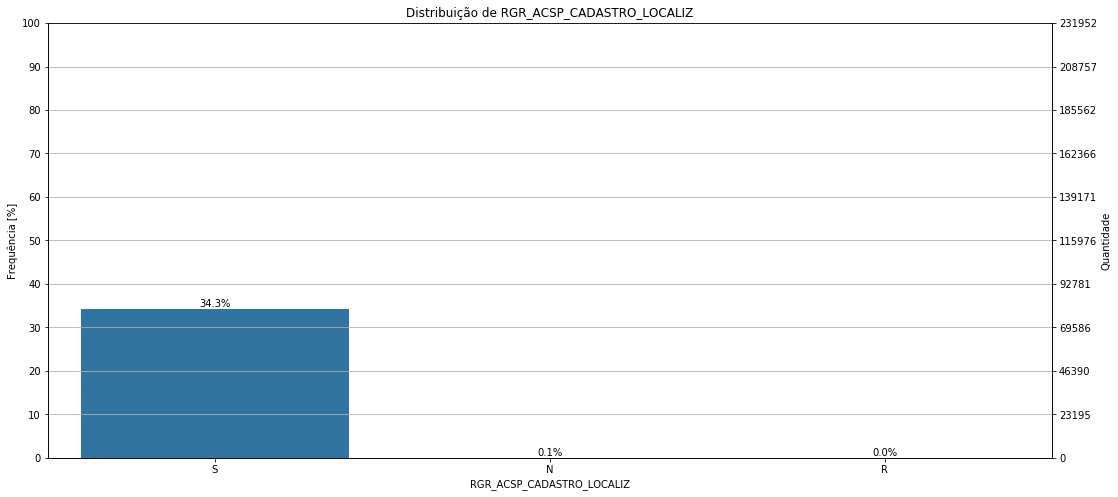

In [252]:
plotarFrequencia(dados, 'RGR_ACSP_CADASTRO_LOCALIZ')

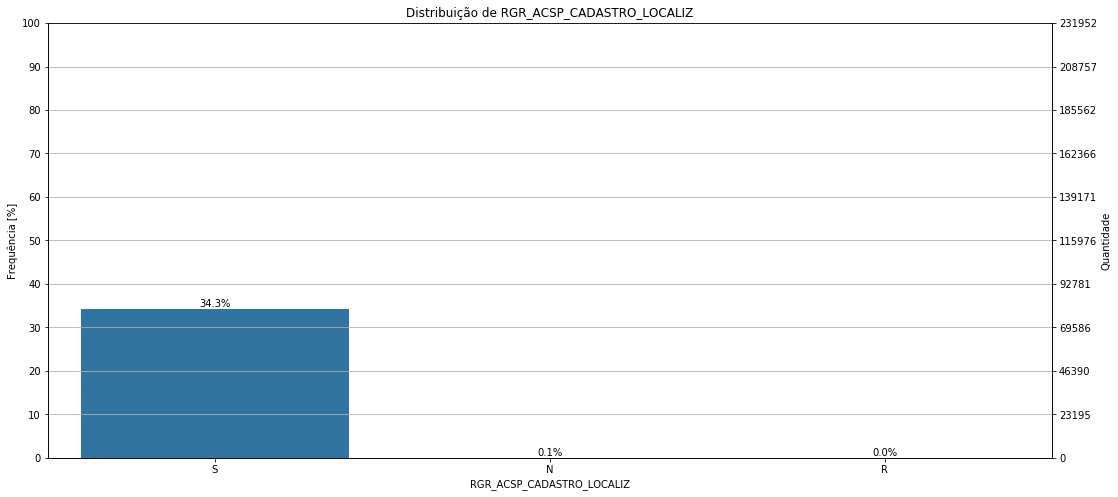

In [253]:
plotarFrequencia(dados, 'RGR_ACSP_CADASTRO_LOCALIZ')

In [254]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_CADASTRO_LOCALIZ'] = dados['RGR_ACSP_CADASTRO_LOCALIZ'].fillna('MISSING')

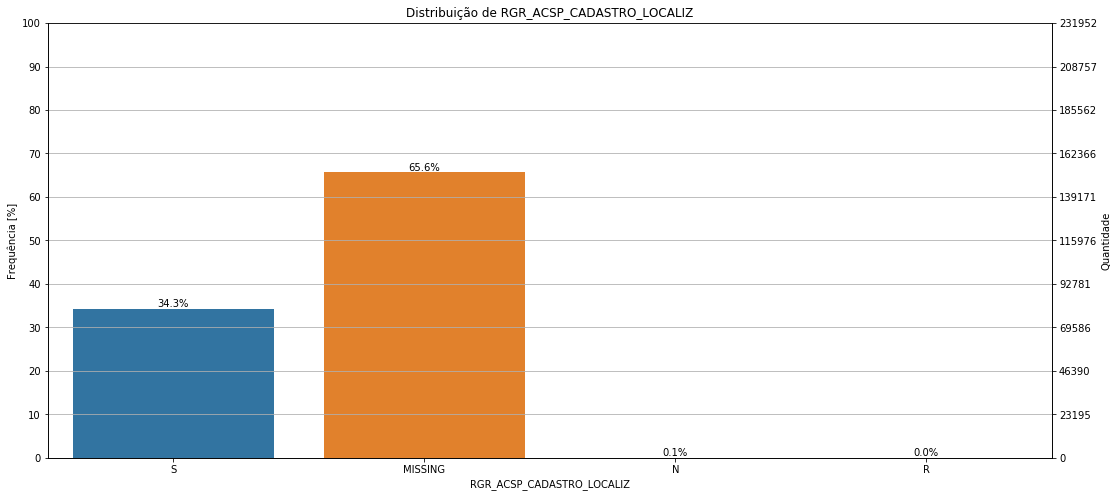

In [255]:
plotarFrequencia(dados, 'RGR_ACSP_CADASTRO_LOCALIZ')

In [256]:
dummies.append('RGR_ACSP_CADASTRO_LOCALIZ')

In [257]:
dummies.append('GTWR_0021_TEM_DEBS')

In [258]:
dadosMissing(dados)

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_CEP_CONFERE - object:        16570
RGR_ACSP_CPF_TEM_RESTRICAO - object:        152399
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        84893
RGR_NOME_MAE_CONFERE - object:        158011
RGR_RFPF_CPF_CANCELADO - object:        23932
RGR_RFPF_CPF_ENCONTRADO - object:        23769
RGR_RFPF_CPF_PENDE

In [259]:
dummies

['GTWR_0001_SITUACAO_CADASTRAL',
 'GTWR_0021_SITUACAO_DECLARACAO',
 'GTWR_0021_TEM_DEBS',
 'GTWR_0021_TEM_RESTITUICAO',
 'GTWR_0182_EXISTE_NDAC_DOCS_SOLICS',
 'RGR_ACSP_CADASTRO_LOCALIZ',
 'GTWR_0021_TEM_DEBS']

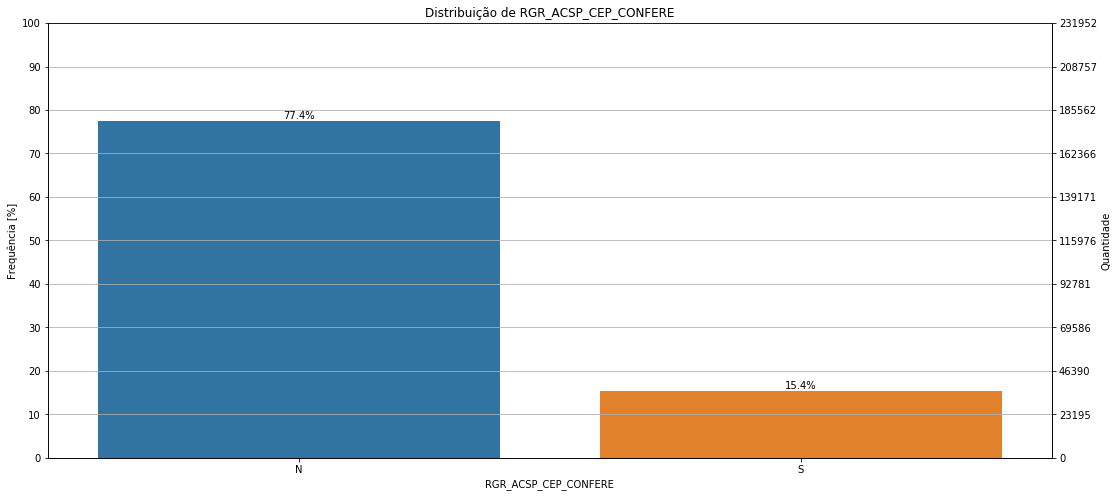

In [260]:
plotarFrequencia(dados, 'RGR_ACSP_CEP_CONFERE')

In [261]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_CEP_CONFERE'] = dados['RGR_ACSP_CEP_CONFERE'].fillna('MISSING')

In [262]:
dummies.append('RGR_ACSP_CEP_CONFERE')

In [263]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_CADASTRO_LOCALIZ'] = dados['RGR_ACSP_CADASTRO_LOCALIZ'].fillna('MISSING')

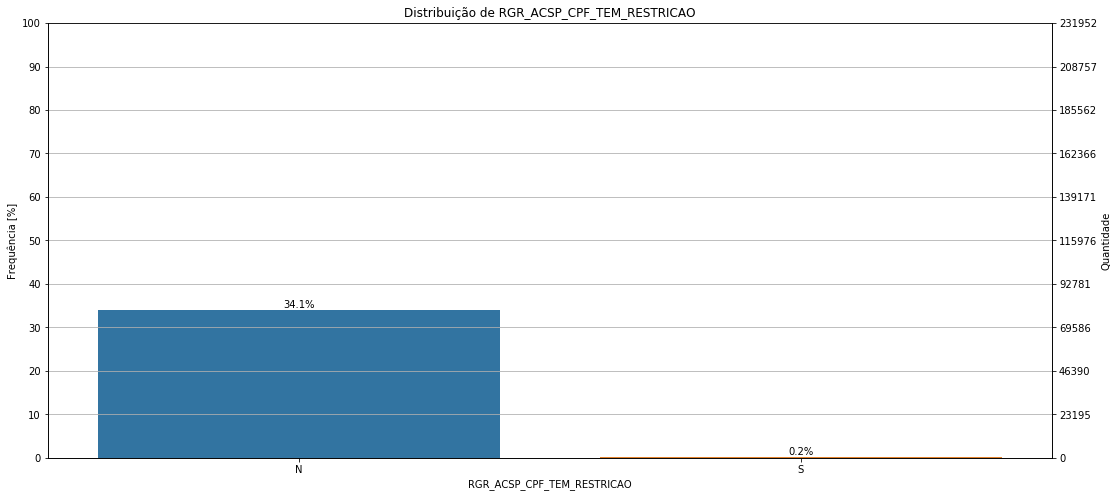

In [264]:
plotarFrequencia(dados, 'RGR_ACSP_CPF_TEM_RESTRICAO')

In [265]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_CPF_TEM_RESTRICAO'] = dados['RGR_ACSP_CPF_TEM_RESTRICAO'].fillna('MISSING')

In [266]:
dummies.append('RGR_ACSP_CPF_TEM_RESTRICAO')

In [267]:
dadosMissing(dados)

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
RGR_ACSP_DOC_ROUBADO - object:        154088
RGR_ACSP_DT_NASC_CONFERE - object:        154123
RGR_ACSP_DT_NASC_EXISTE - object:        154088
RGR_ACSP_NOME_MAE_EXISTE - object:        154088
RGR_ANATEL_PROF_NULO - object:        15655
RGR_CARENCIA - object:        230577
RGR_IRPF_NAO_DECLARADO - object:        27134
RGR_IRPF_RENDA_MAIOR_QUE_PISO - object:        72603
RGR_IRPF_SIST_RESPONDE - object:        21104
RGR_NAT_OCUP_SEM_TEL_PROF - object:        84893
RGR_NOME_MAE_CONFERE - object:        158011
RGR_RFPF_CPF_CANCELADO - object:        23932
RGR_RFPF_CPF_ENCONTRADO - object:        23769
RGR_RFPF_CPF_PENDENTE - object:        23792
RGR_RFPF_CPF_SUSPENSO - object:        23844
RGR_RFPF_NOME_CONFERE -

## Todas de uma vez

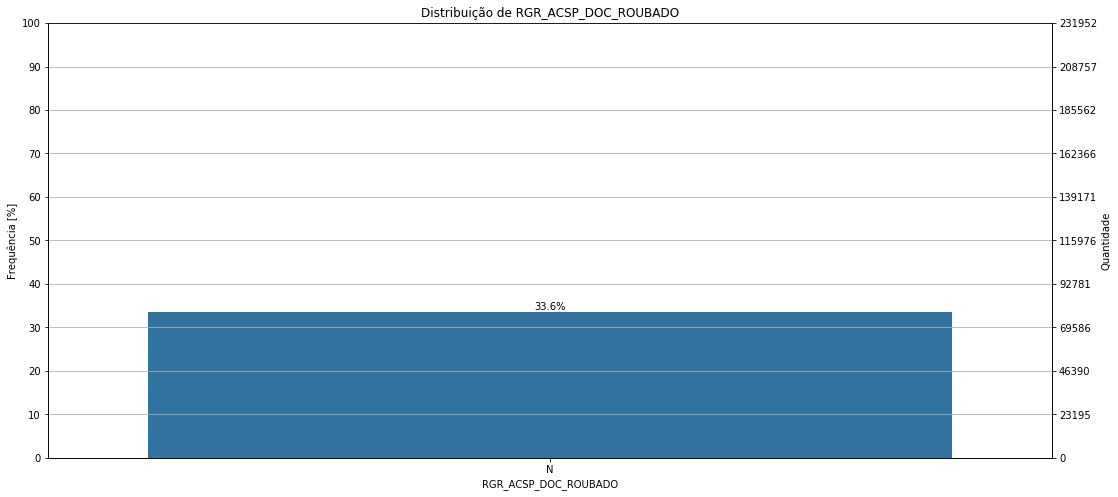

In [268]:
plotarFrequencia(dados, 'RGR_ACSP_DOC_ROUBADO')

In [269]:
dados = dados.drop('RGR_ACSP_DOC_ROUBADO', axis=1)

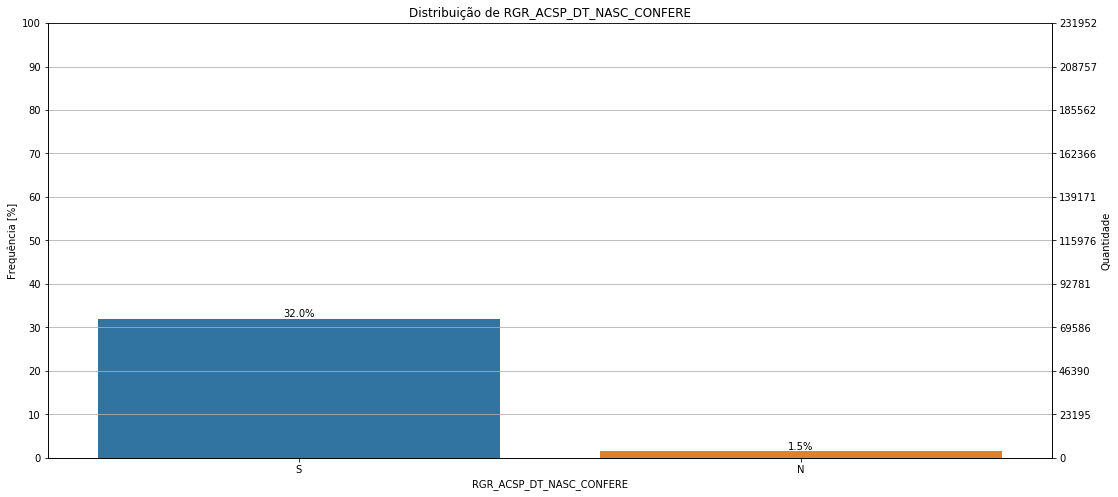

In [270]:
plotarFrequencia(dados, 'RGR_ACSP_DT_NASC_CONFERE')

In [271]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_DT_NASC_CONFERE'] = dados['RGR_ACSP_DT_NASC_CONFERE'].fillna('MISSING')

In [272]:
dummies.append('RGR_ACSP_DT_NASC_CONFERE')

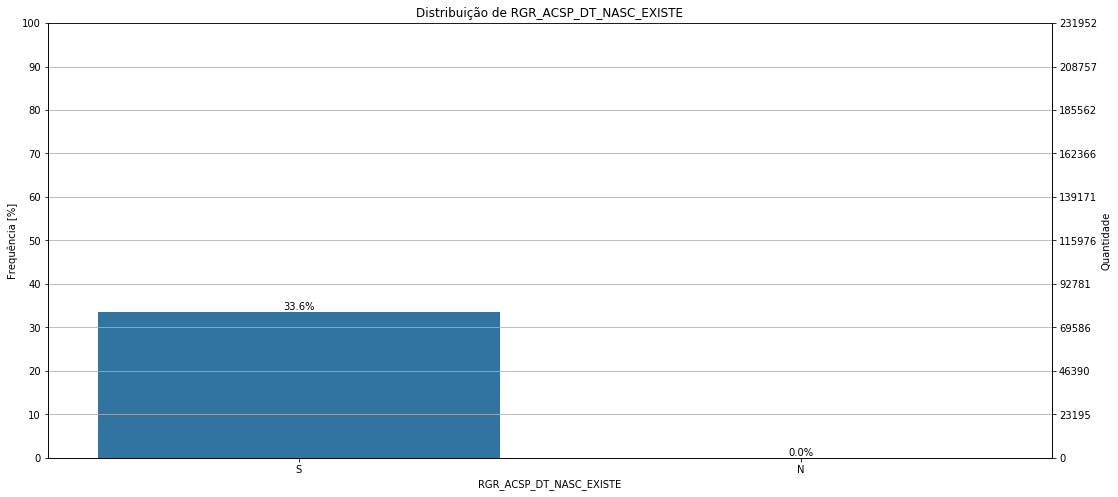

In [273]:
plotarFrequencia(dados, 'RGR_ACSP_DT_NASC_EXISTE')

In [274]:
# Variável sem informação
dados = dados.drop('RGR_ACSP_DT_NASC_EXISTE', axis=1)

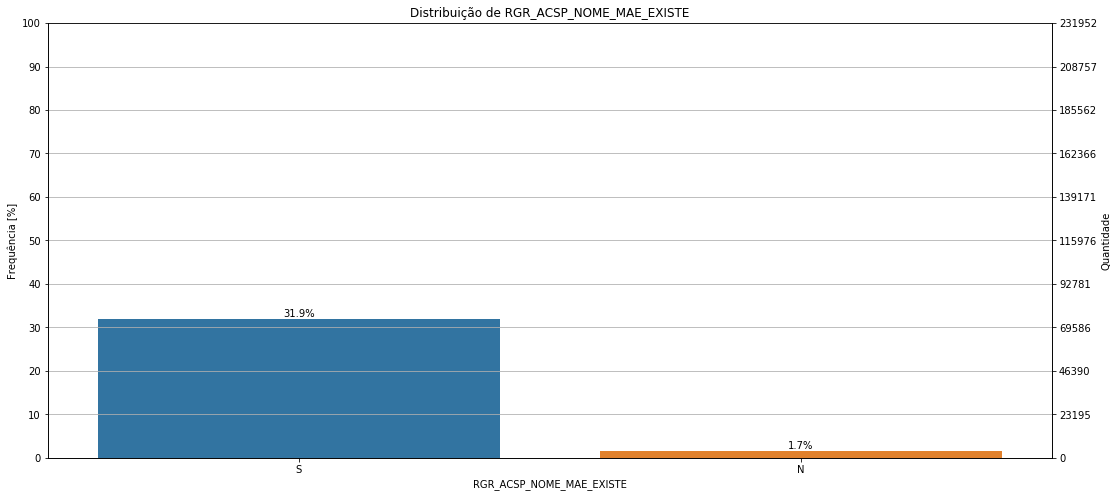

In [275]:
plotarFrequencia(dados, 'RGR_ACSP_NOME_MAE_EXISTE')

In [276]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ACSP_NOME_MAE_EXISTE'] = dados['RGR_ACSP_NOME_MAE_EXISTE'].fillna('MISSING')

In [277]:
dummies.append('RGR_ACSP_NOME_MAE_EXISTE')

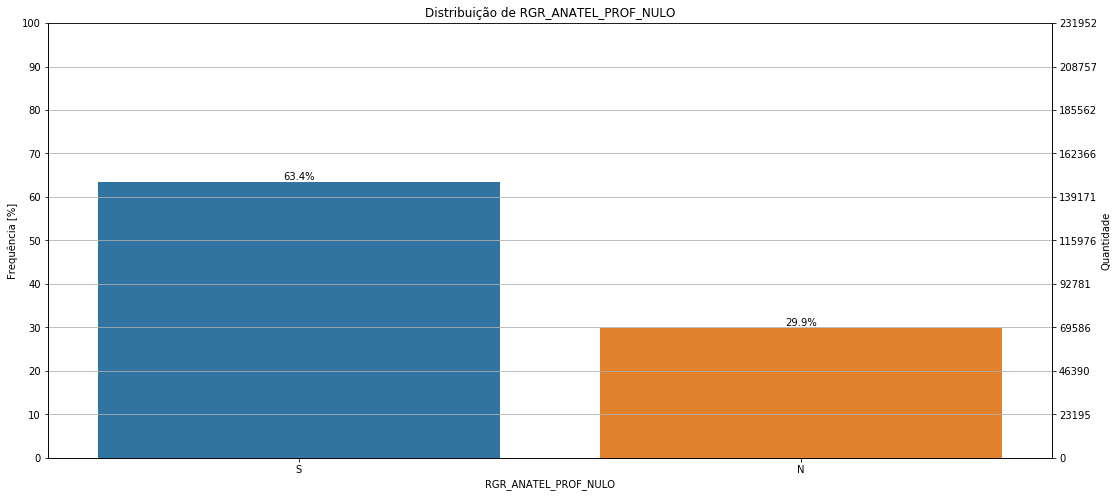

In [278]:
plotarFrequencia(dados, 'RGR_ANATEL_PROF_NULO')

In [279]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_ANATEL_PROF_NULO'] = dados['RGR_ANATEL_PROF_NULO'].fillna('MISSING')

In [280]:
dummies.append('RGR_ANATEL_PROF_NULO')

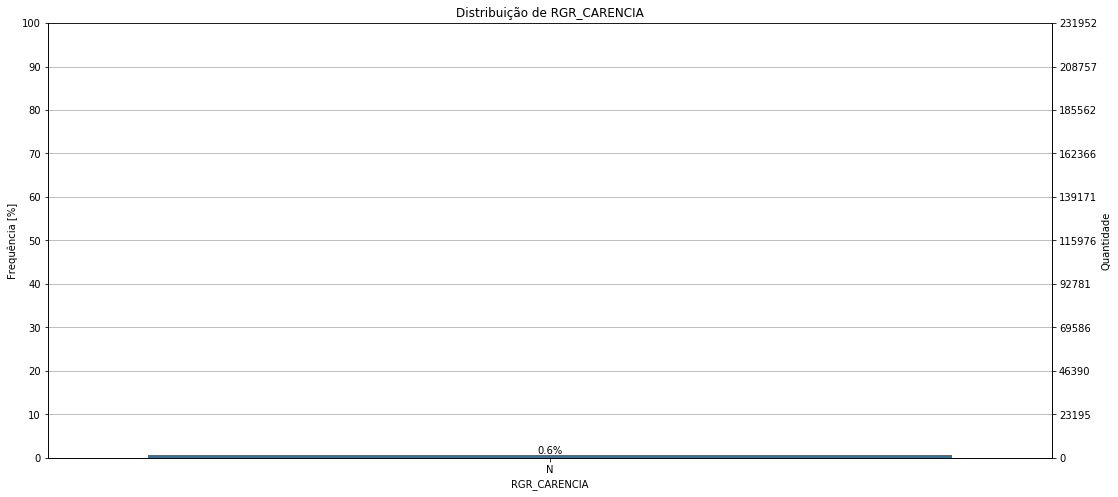

In [281]:
plotarFrequencia(dados, 'RGR_CARENCIA')

In [282]:
# Variável sem informação
dados = dados.drop('RGR_CARENCIA', axis=1)

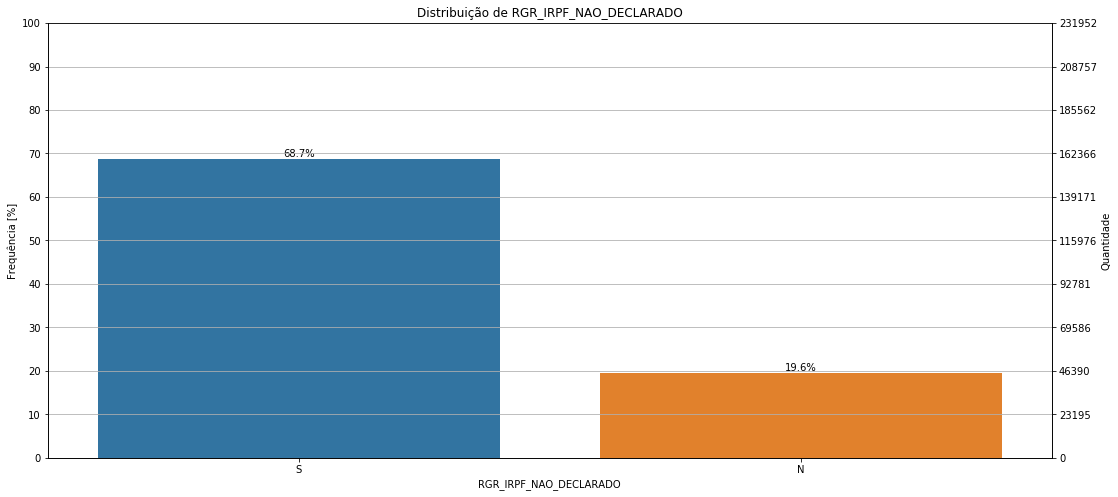

In [283]:
plotarFrequencia(dados, 'RGR_IRPF_NAO_DECLARADO')

In [284]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_IRPF_NAO_DECLARADO'] = dados['RGR_IRPF_NAO_DECLARADO'].fillna('RGR_IRPF_NAO_DECLARADO')

In [285]:
dummies.append('RGR_IRPF_NAO_DECLARADO')

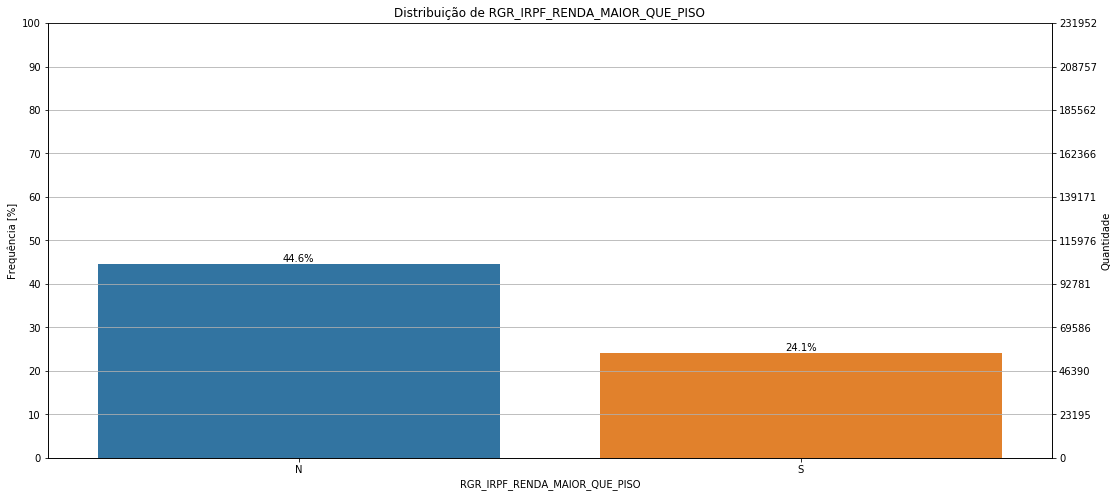

In [286]:
plotarFrequencia(dados, 'RGR_IRPF_RENDA_MAIOR_QUE_PISO')

In [287]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_IRPF_RENDA_MAIOR_QUE_PISO'] = dados['RGR_IRPF_RENDA_MAIOR_QUE_PISO'].fillna('MISSING')

In [288]:
dummies.append('RGR_IRPF_RENDA_MAIOR_QUE_PISO')

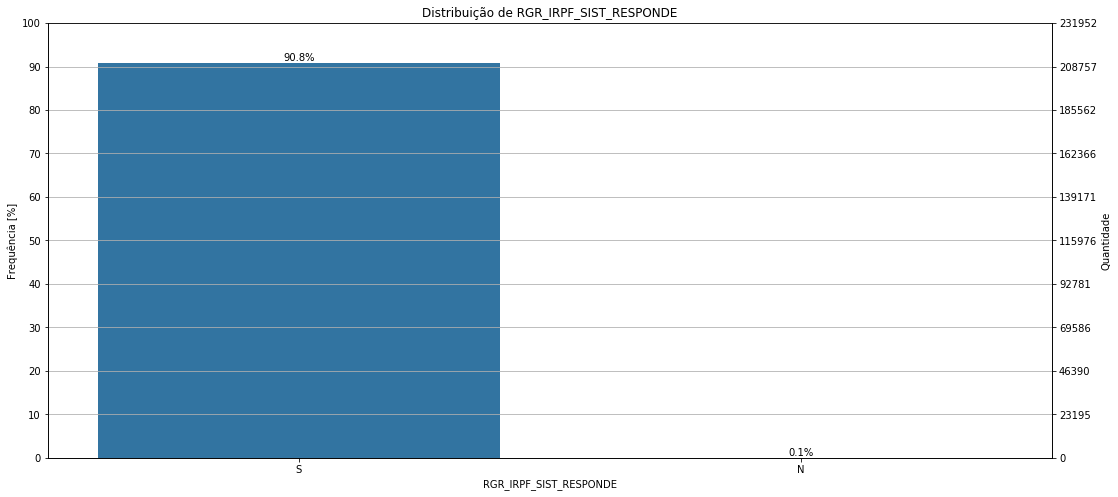

In [289]:
plotarFrequencia(dados, 'RGR_IRPF_SIST_RESPONDE')

In [290]:
# Variável sem informação
dados = dados.drop('RGR_IRPF_SIST_RESPONDE', axis=1)

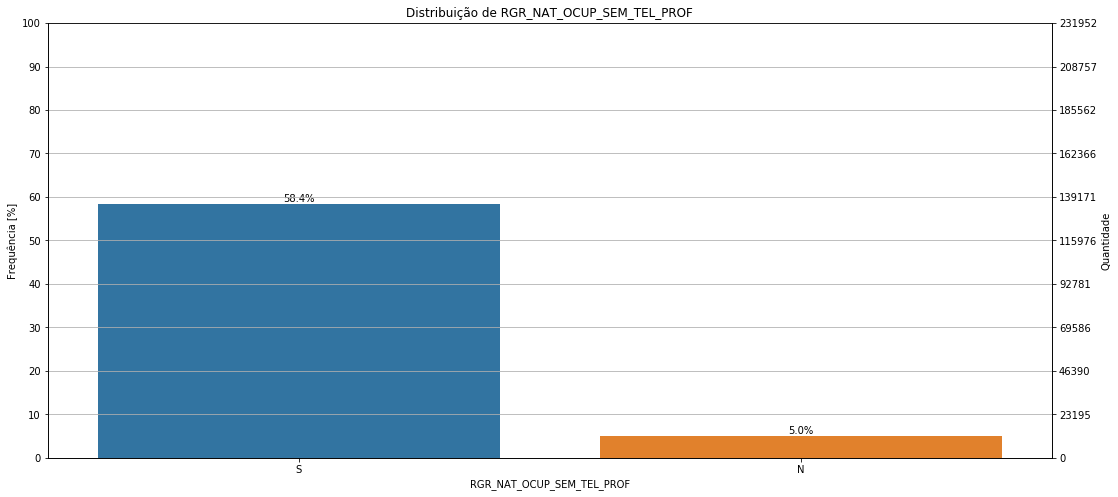

In [291]:
plotarFrequencia(dados, 'RGR_NAT_OCUP_SEM_TEL_PROF')

In [292]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_NAT_OCUP_SEM_TEL_PROF'] = dados['RGR_NAT_OCUP_SEM_TEL_PROF'].fillna('MISSING')

In [293]:
dummies.append('RGR_NAT_OCUP_SEM_TEL_PROF')

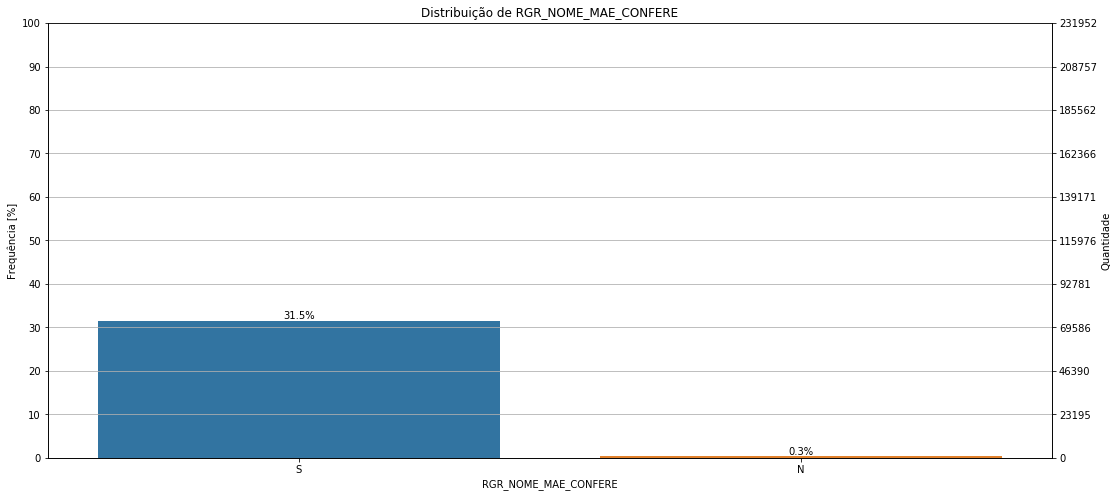

In [294]:
plotarFrequencia(dados, 'RGR_NOME_MAE_CONFERE')

In [295]:
# variável sem informação
dados = dados.drop('RGR_NOME_MAE_CONFERE', axis=1)

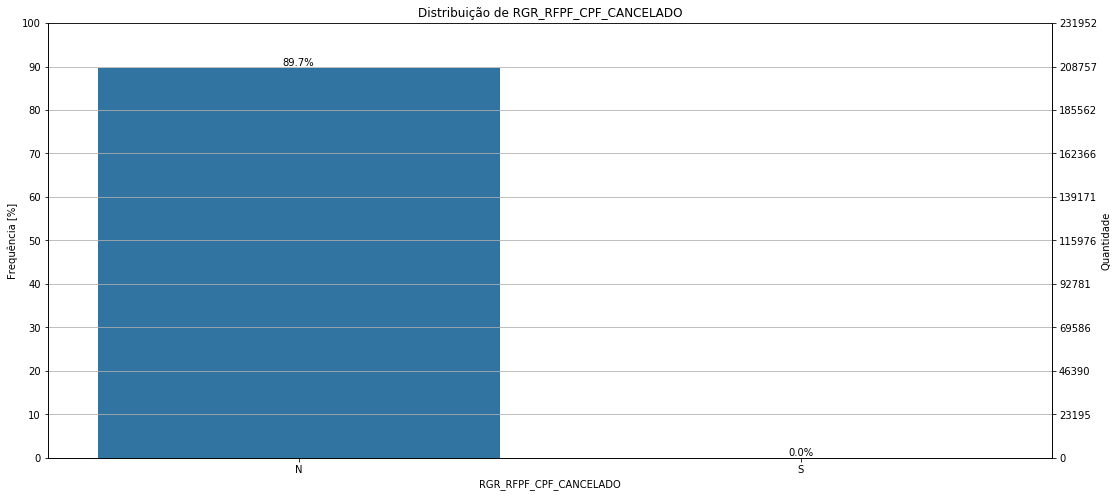

In [296]:
plotarFrequencia(dados, 'RGR_RFPF_CPF_CANCELADO')

In [297]:
# variável sem informação
dados = dados.drop('RGR_RFPF_CPF_CANCELADO', axis=1)

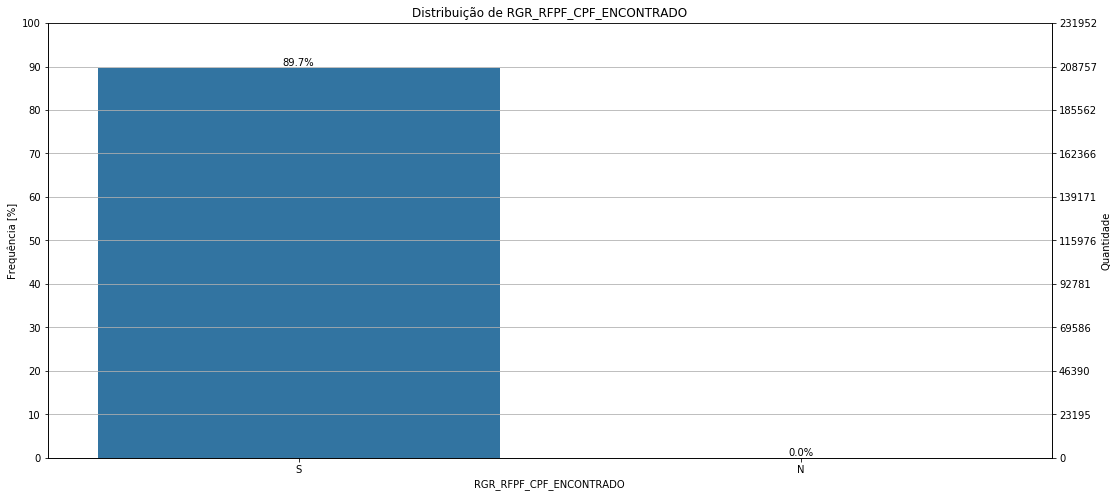

In [298]:
plotarFrequencia(dados, 'RGR_RFPF_CPF_ENCONTRADO')

In [299]:
# variável sem informação
dados = dados.drop('RGR_RFPF_CPF_ENCONTRADO', axis=1)

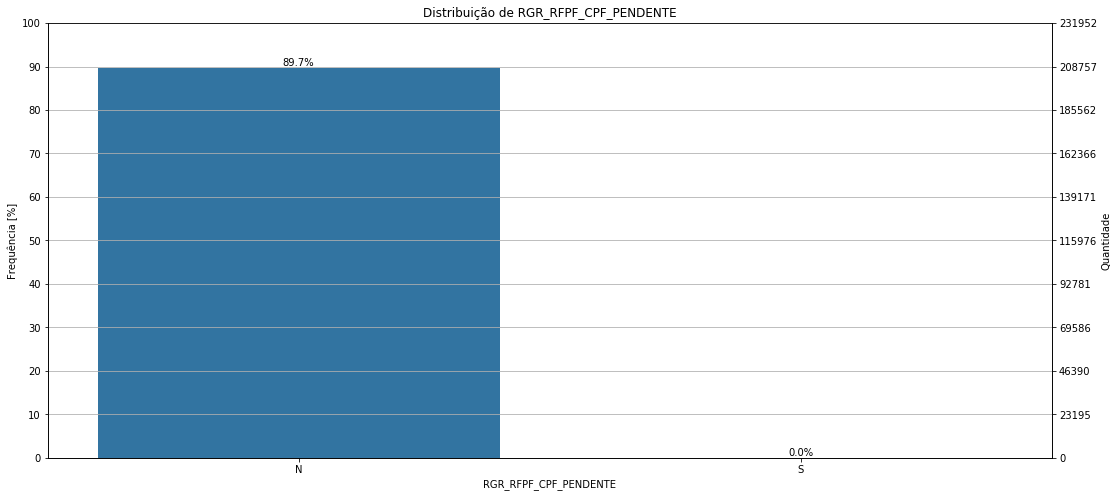

In [300]:
plotarFrequencia(dados, 'RGR_RFPF_CPF_PENDENTE')

In [301]:
# variável sem informação
dados = dados.drop('RGR_RFPF_CPF_PENDENTE', axis=1)

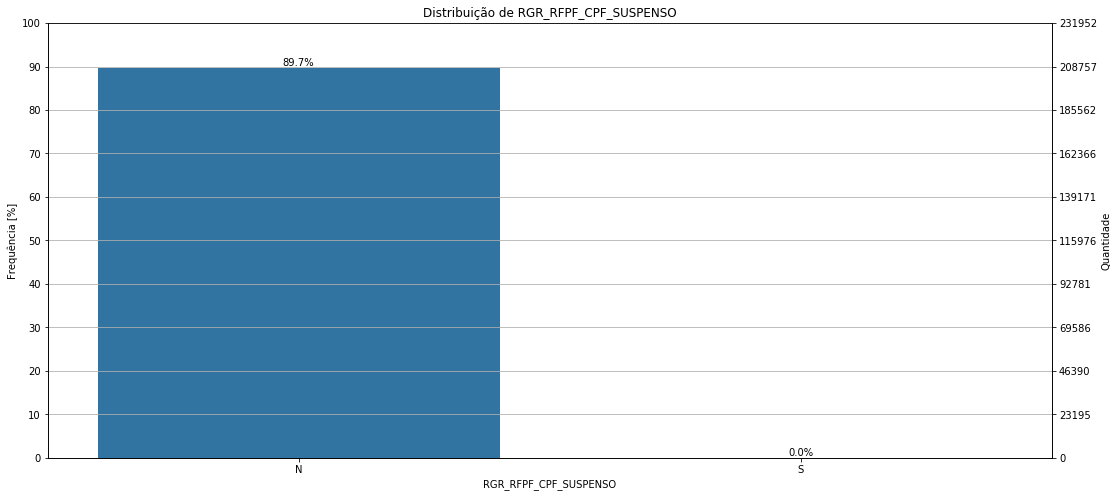

In [302]:
plotarFrequencia(dados, 'RGR_RFPF_CPF_SUSPENSO')

In [303]:
# variável sem informação
dados = dados.drop('RGR_RFPF_CPF_SUSPENSO', axis=1)

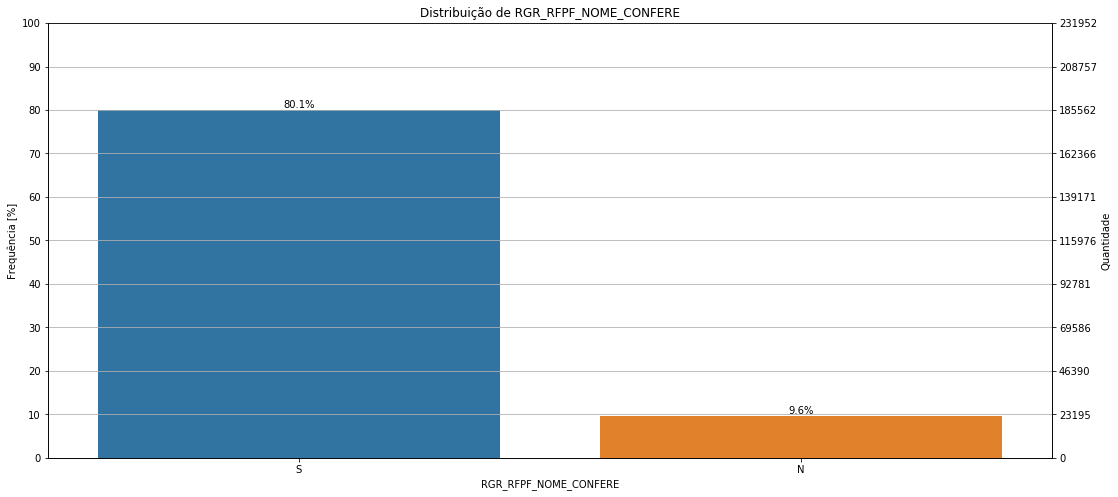

In [304]:
plotarFrequencia(dados, 'RGR_RFPF_NOME_CONFERE')

In [305]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_RFPF_NOME_CONFERE'] = dados['RGR_RFPF_NOME_CONFERE'].fillna('MISSING')

In [306]:
dummies.append('RGR_RFPF_NOME_CONFERE')

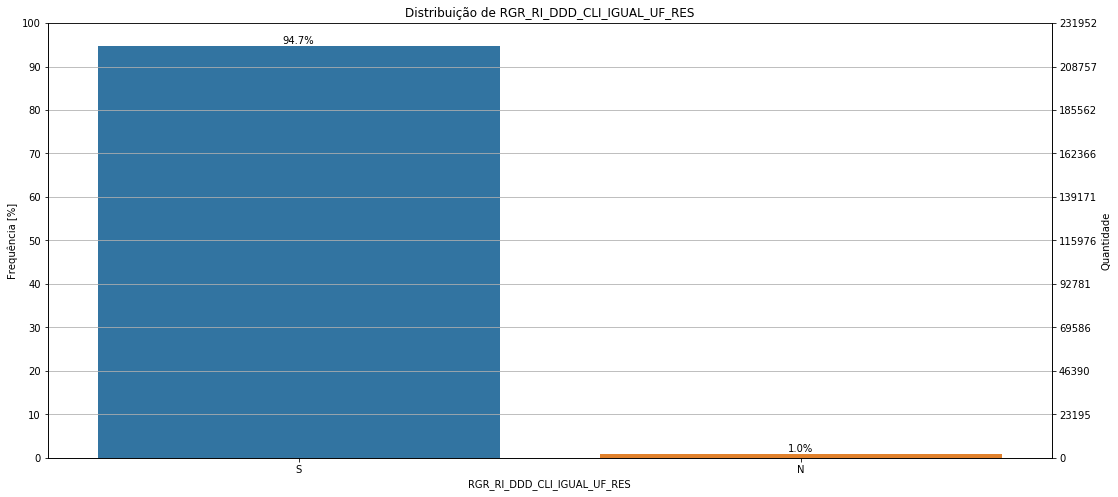

In [307]:
plotarFrequencia(dados, 'RGR_RI_DDD_CLI_IGUAL_UF_RES')

In [308]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_RI_DDD_CLI_IGUAL_UF_RES'] = dados['RGR_RI_DDD_CLI_IGUAL_UF_RES'].fillna('MISSING')

In [309]:
dummies.append('RGR_RI_DDD_CLI_IGUAL_UF_RES')

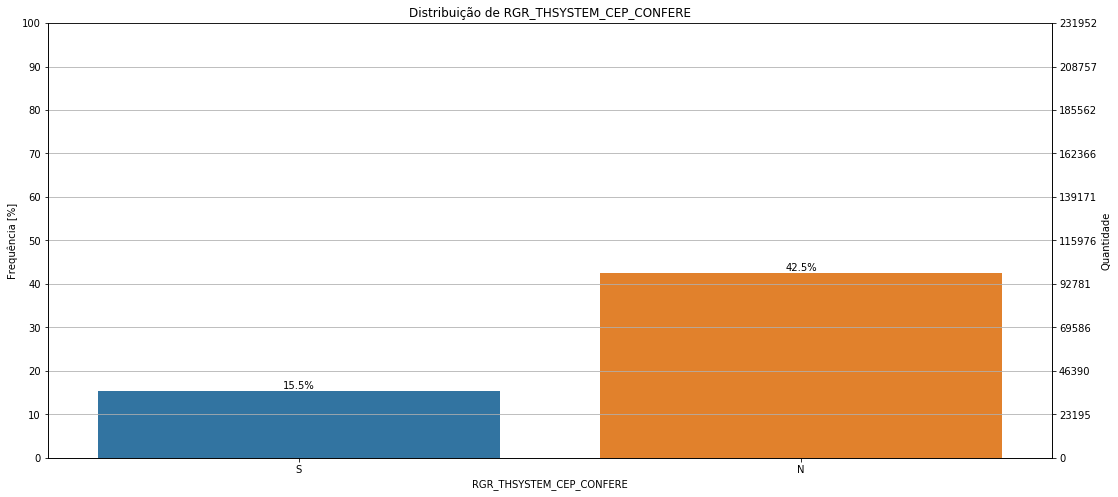

In [310]:
plotarFrequencia(dados, 'RGR_THSYSTEM_CEP_CONFERE')

In [311]:
# Categorizando as variáveis missing com step funtcion
dados['RGR_THSYSTEM_CEP_CONFERE'] = dados['RGR_THSYSTEM_CEP_CONFERE'].fillna('MISSING')

In [312]:
dummies.append('RGR_THSYSTEM_CEP_CONFERE')

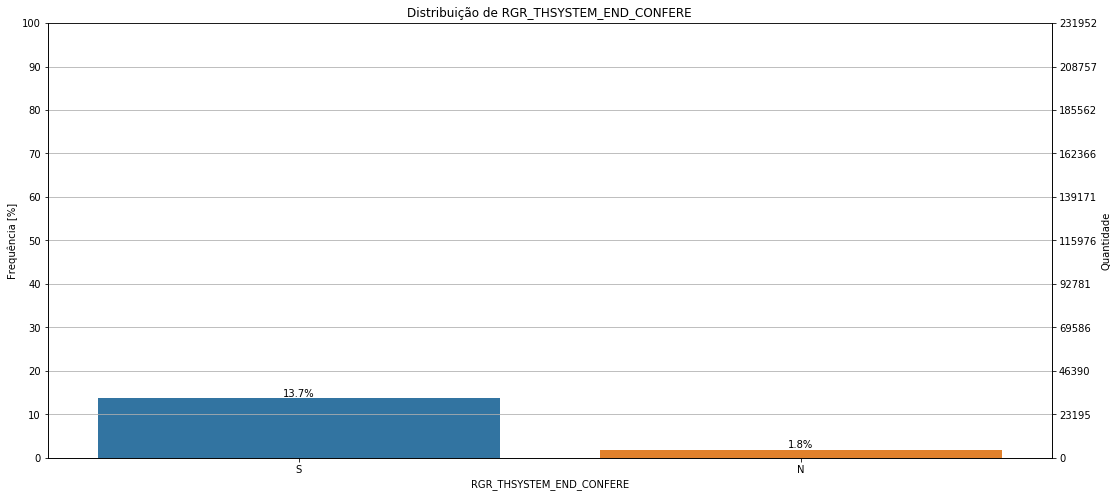

In [313]:
plotarFrequencia(dados, 'RGR_THSYSTEM_END_CONFERE')

In [314]:
# variável sem informação
dados = dados.drop('RGR_THSYSTEM_END_CONFERE', axis=1)

In [315]:
dadosMissing(dados)

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
TEVE_REG_CARTAO_CREDITO - object:        152399
TEVE_REG_CREDITO_DIRETO - object:        152399
TEVE_REG_CREDITO_PESSOAL - object:        152399
TEVE_REG_OUTROS - object:        152399


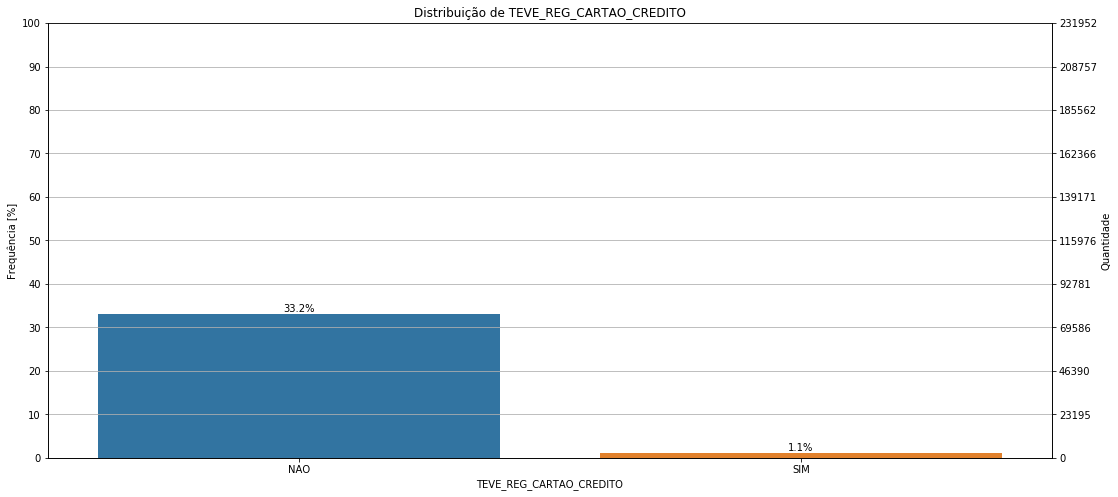

In [316]:
plotarFrequencia(dados, 'TEVE_REG_CARTAO_CREDITO')

In [318]:
dadosMissing(dados)

GTWR_0182_QTDE_SCPC_CRED_CARTAO_CREDITO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_DIRETO - float64:        152399
GTWR_0182_QTDE_SCPC_CRED_PESSOAL - float64:        152399
GTWR_0182_QTDE_SCPC_OUTROS - float64:        152399
PROP_DATA_NASCIMENTO_TITULAR - object:        9957
TEVE_REG_CARTAO_CREDITO - object:        152399
TEVE_REG_CREDITO_DIRETO - object:        152399
TEVE_REG_CREDITO_PESSOAL - object:        152399
TEVE_REG_OUTROS - object:        152399


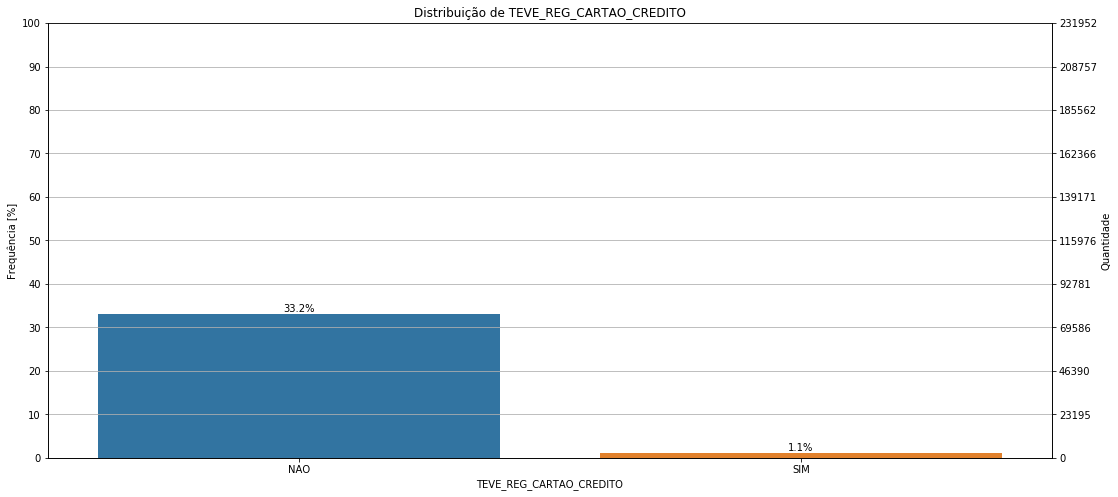

In [321]:
plotarFrequencia(dados, 'TEVE_REG_CARTAO_CREDITO')

In [322]:
dados['TEVE_REG_CARTAO_CREDITO'] = dados['TEVE_REG_CARTAO_CREDITO'].fillna('NAO')

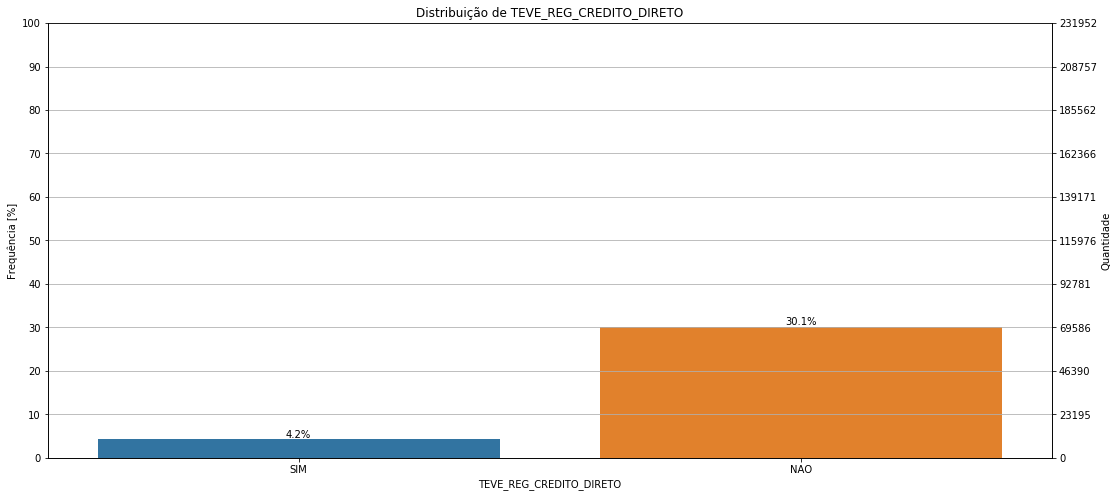

In [324]:
plotarFrequencia(dados, 'TEVE_REG_CREDITO_DIRETO')

In [325]:
dados['TEVE_REG_CREDITO_DIRETO'] = dados['TEVE_REG_CREDITO_DIRETO'].fillna('NAO')

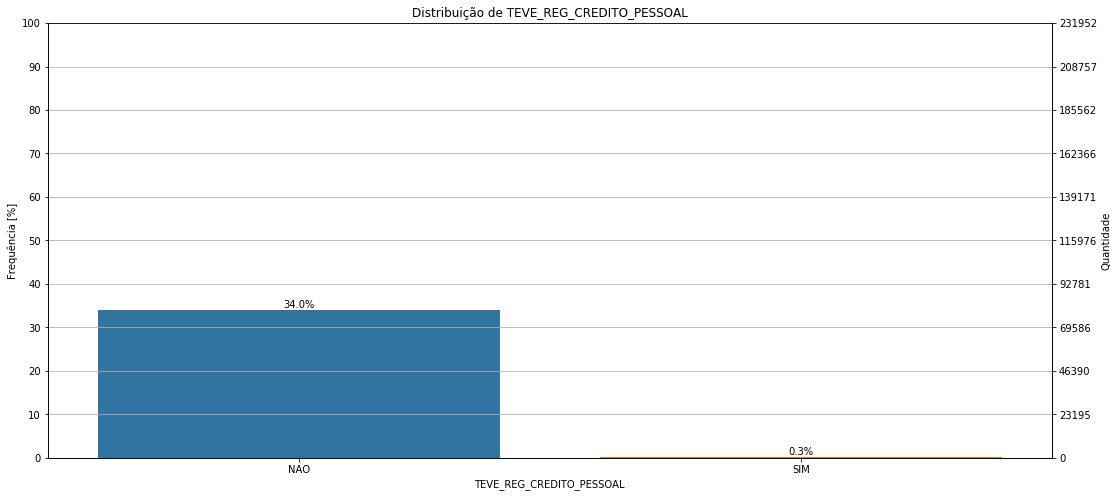

In [327]:
plotarFrequencia(dados, 'TEVE_REG_CREDITO_PESSOAL')

In [328]:
dados['TEVE_REG_CREDITO_PESSOAL'] = dados['TEVE_REG_CREDITO_PESSOAL'].fillna('NAO')

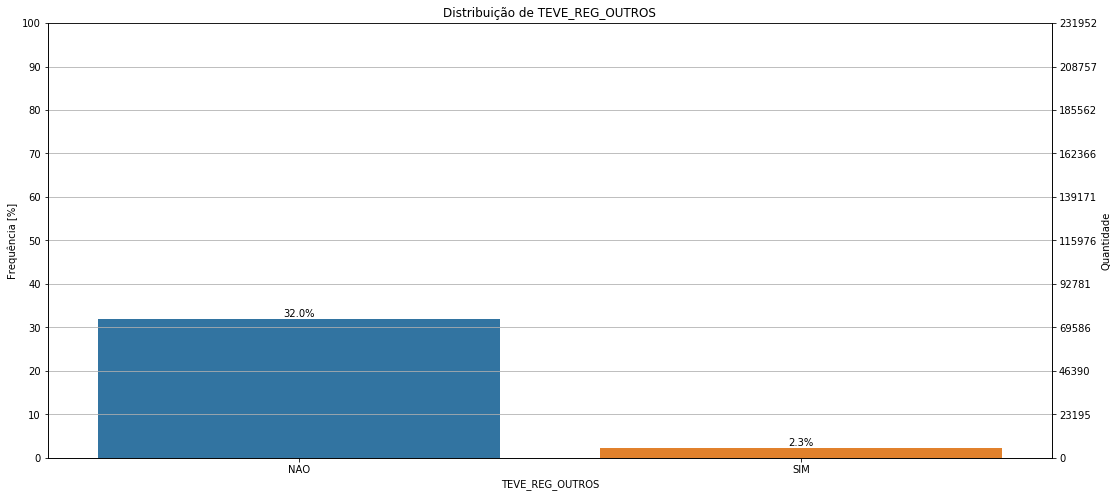

In [330]:
plotarFrequencia(dados, 'TEVE_REG_OUTROS')

In [331]:
dados['TEVE_REG_OUTROS'] = dados['TEVE_REG_OUTROS'].fillna('NAO')